In [1]:
# Aquí crido l'script que t'he deixat al directori /home/anoguera/scripts/src/globalFunctionsAina.R
source("/home/anoguera/scripts/src/globalFunctionsAina.R")

phs <- fread('/home/anoguera/Data/tableGenesHtmlRefereeCorrected.tab') %>% filter(chr != 'chrX')

Warning message:
“replacing previous import ‘lifecycle::last_warnings’ by ‘rlang::last_warnings’ when loading ‘tibble’”
Warning message:
“replacing previous import ‘vctrs::data_frame’ by ‘tibble::data_frame’ when loading ‘dplyr’”

Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



Attaching package: ‘data.table’


The following objects are masked from ‘package:dplyr’:

    between, first, last


── Attaching packages ──────────────────────────────────────────────────────────── tidyverse 1.3.0 ──

✔ ggplot2 3.3.6     ✔ purrr   0.3.4
✔ tibble  3.0.1     ✔ stringr 1.4.0
✔ tidyr   1.1.0     ✔ forcats 0.5.0
✔ readr   1.3.1     

── Conflicts ─────────────────────────────────────────────────────────────── tidyverse_conflicts() ──
✖ data.table::between() masks dplyr::between()
✖ dplyr::filter()       masks stats::filter()
✖ data.table::first()  

In [2]:
####Gràfic de les edats estimades de variants amb iSAFE significatiu vs no significatiu

#S'introdueixen els inicis i finals com a dos vectors, de forma que el primer valor d'inicis es correspon al primer de finals;
#i length(inicis)=length(finals). El vector de cromosomes no ha de ser de la mateixa longitud: un cop per chr és suficient. 
#S'han d'introduir també les taules atlas i isafe
#Es considera significant un valor d'iSAFE > 0.1 i es filtren les edats d'atlas amb qualitat inferior a 0.5
agemode_isafe_plot <- function(chrom = NA, inicis = NA, finals = NA, PHS = phs, pop_color = popPal,
                               AFR = AFRpops, EAS = EASpops, EUR = EURpops, SAS = SASpops, AMR = TRUE) {
    #Miro si s'han introduit inicis/finals concrets o si serà per tots
    if (all(!is.na(chrom))) {
        PHS <- PHS %>% filter(gsub('chr','',chr) %in% chrom)
        if (all(!is.na(inicis)) & all(!is.na(finals))) {
            #Això no portarà problemes perquè totes les posicions d'inici i de final són úniques, independentment de cromosoma:
            #No s'ha d'especificar a quin cromosoma pertany una posició d'inici 
            PHS <- PHS %>% filter(start %in% inicis & end %in% finals)
        }
    }
    #Creo una data table buida
    taula <- data.table()
    #Es repeteix per cada registre de PHS que quedi després de filtrar els desitjats
    for (n in 1:nrow(PHS)) {
        pos_inici <- PHS$start[n]
        pos_final <- PHS$end[n]
        chr <- gsub('chr', '', PHS$chr[n])
        region <- paste0(chr, ':', pos_inici, '-', pos_final)
        #Creo la taula que ja son les d'iSAFE i atlas juntes i filtro per la QualScore
        merged_temp <- getInfoRegion(region) %>% filter(QualScore_Jnt >= 0.5) 
        #Si AMR == FALSE vol dir que s'ha d'eliminar la informació de les poblacions americanes
        if (AMR == FALSE) {
            merged_temp <- merged_temp[, -c("CLM", "MXL", "PEL", "PUR")]
        }
        #Faig el pivot longer, filtro els valors NA i classifico en iSAFE significant o no
        merged_temp <- merged_temp %>%
            pivot_longer(cols = c('ACB':'YRI'), names_to = 'pop', values_to='isafe') %>%
            filter(!is.na(isafe)) %>% mutate(grup = case_when(isafe >= 0.1 ~ 'Significant', TRUE ~ 'Nonsignificant'))
        #Això serveix per conseguir un vector amb les poblacions que tenen alguna variant significatica en iSAFE per aquesta regió
        pob_significatiu <- merged_temp %>% group_by(pop) %>% filter(grup == 'Significant') %>%
            summarise(significatiu = length(grup), .groups = 'keep') %>% collect %>% .[[1]]
        #Filtro la taula per quedar-me només les poblacions amb iSAFEs significatius
        #Una vegada filtrada, creo una columna nova que distingeixi la regió (segons els gens que conté)
        merged_temp <- merged_temp %>% filter(pop %in% pob_significatiu) %>%
            mutate(region = paste0(PHS$GeneID[n],'\n(', region, ')'), 
                   metapop = case_when(pop %in% AFR ~ 'AFR',
                                       pop %in% EUR ~ 'EUR',
                                       pop %in% EAS ~ 'EAS',
                                       pop %in% SAS ~ 'SAS',
                                       TRUE ~ 'AMR'))
        #I en cada iteració, afegeixo la taula temporal a una taula gran
        taula <- bind_rows(taula, merged_temp)
    }
    #Faig una llista de les poblacions que es representaran per filtrar pop_colors (deixant-ho ordenat per metapoblacions)
    pops <- unique(taula %>% arrange(metapop) %>% pull(pop))
    pop_color <- pop_color[pops]
    #Faig el gràfic, separant per regió amb el facet_wrap(). El factor de la x em serveix per ordenar les poblacions com estan a la taula
    #(per metapoblació). Ordeno les poblacions tal i com estan a pop_color
    options(repr.plot.width = 20, repr.plot.height = 10, warn = 1)
    grafic <- taula %>% arrange(metapop) %>%
        ggplot(mapping = aes(x= factor(pop, levels = unique(pop)), y=AgeMode_Jnt/1000, fill=pop, color = grup)) +
        geom_boxplot() + scale_color_manual(values = c('black','#6b0000'), name= 'iSAFE') +
        scale_fill_manual(values = pop_color, breaks = names(pop_color), name = 'Population') + theme(text = element_text(size = 15)) +
        facet_wrap(~region, scales = 'free', ncol = 4) + labs(x='', y='Estimated variant age (thousands of generations)')
    #Si enlloc de facet_wrap es fa facet_grid, posant l'argument space='free', la mida de cada gràfic s'ajusta automàticament. S'ha de treure l'argument nrow
    return(grafic)
}

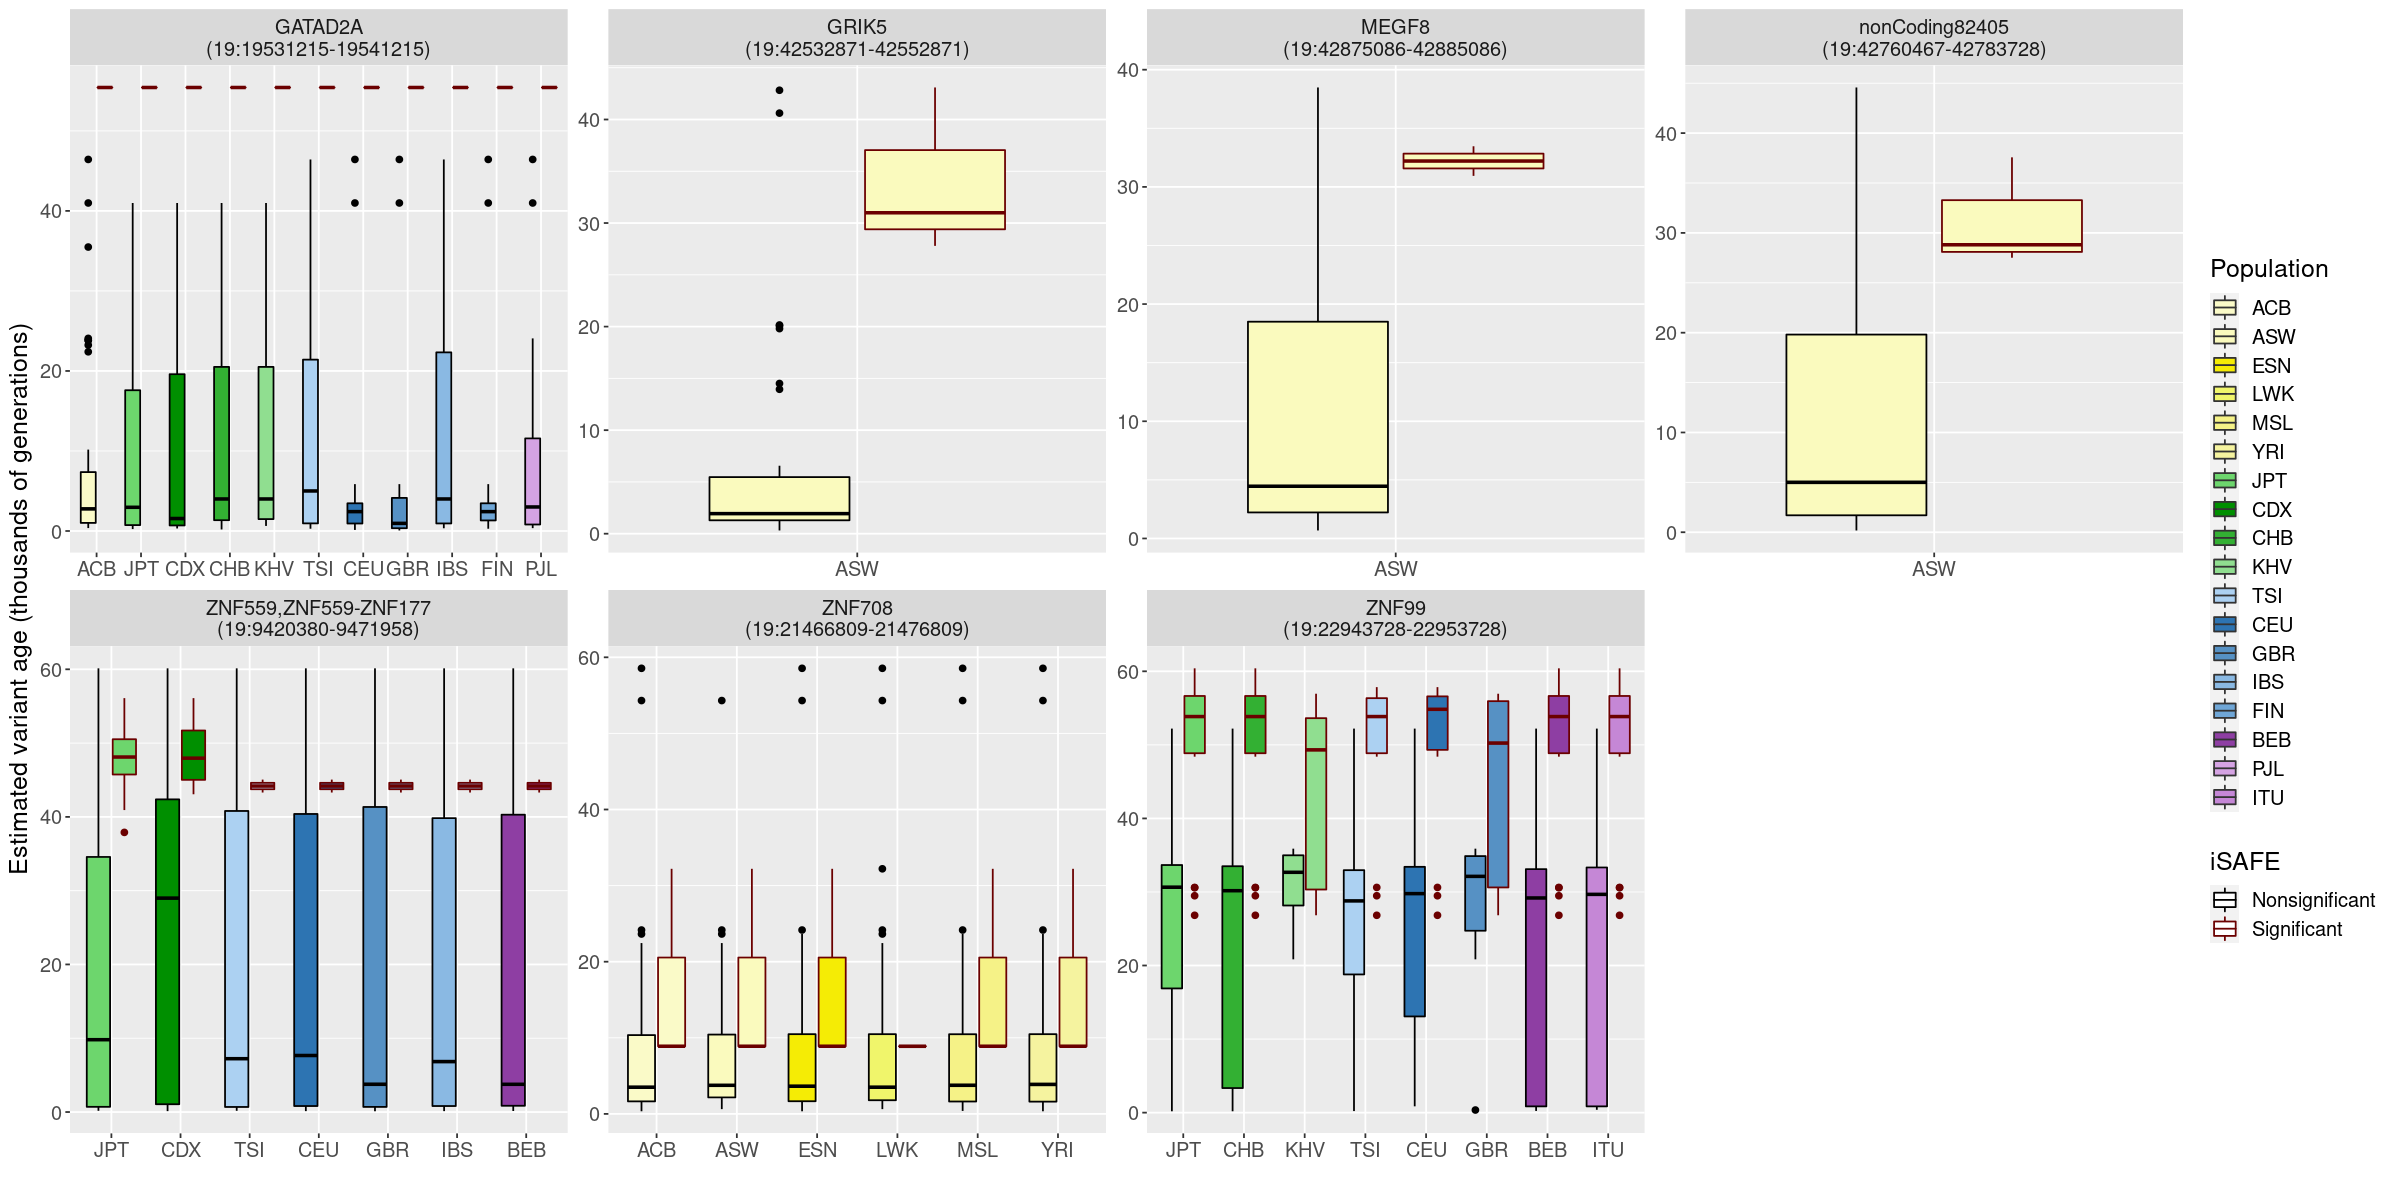

In [9]:
agemode_isafe_plot(chrom = 19, AMR = FALSE)

In [ ]:
###Gràfic per plotejar una regió concreta on es mira si l'edat estimada de les variants amb iSAFE significatiu és coherent entre les poblacions d'una mteapoblació AMB ANOVA

#S'han d'introduir també les taules atlas i isafe
diferencia_edats <- function(chrom, inici, final, pop_color = popPal, 
                             AFR = AFRpops, EAS = EASpops, EUR = EURpops, SAS = SASpops, AMR = TRUE) {
    library(ggsignif)
    #Guardo la regió que es vol representar
    region <- paste0(chrom, ':', inici, '-', final)
    #Em quedo amb la regió corresponent de les taules (i filtro per qualitat de GEVA > 0.5)
    merged_temp <- getInfoRegion(region) %>% filter(QualScore_Jnt >= 0.5) 
    #Si AMR == FALSE vol dir que s'ha d'eliminar la informació de les poblacions americanes
    if (AMR == FALSE) {
        merged_temp <- merged_temp[, -c("CLM", "MXL", "PEL", "PUR")]
    }
    #Faig el pivot longer, filtro els valors NA i classifico en iSAFE significant o no
    merged_temp <- merged_temp %>%
        pivot_longer(cols = c('ACB':'YRI'), names_to = 'pop', values_to='isafe') %>%
        filter(!is.na(isafe)) %>% mutate(grup = case_when(isafe >= 0.1 ~ 'Significant', TRUE ~ 'Nonsignificant'))
    #Això serveix per conseguir un vector amb les poblacions que tenen alguna variant significatica en iSAFE per aquesta regió
    pob_significatiu <- merged_temp %>% group_by(pop) %>% filter(grup == 'Significant') %>%
        summarise(significatiu = length(grup), .groups = 'keep') %>% collect %>% .[[1]]
    #Si no hi ha cap població significativa, s'acaba ja i no es pot representar res
    if (length(pob_significatiu) == 0) {
        print('This region cannot be represented, as no populations have variants with a significant iSAFE value')
    }
    #Filtro la taula per quedar-me només les columnes importants i les poblacions amb iSAFEs significatius
    #Una vegada filtrada, creo una columna nova que distingeixi la metapoblació segons la població i que identifiqui cada combinació de població i rsid individualment
    merged_temp <- merged_temp %>% select(rsid, pop, isafe, AgeMode_Jnt, grup) %>%
        filter(pop %in% pob_significatiu) %>% mutate(metapop = case_when(pop %in% AFR ~ 'AFR',
                                                                         pop %in% EUR ~ 'EUR',
                                                                         pop %in% EAS ~ 'EAS',
                                                                         pop %in% SAS ~ 'SAS',
                                                                         TRUE ~ 'AMR'),
                                                    rsid_pop = paste(rsid, pop, sep=':'))
    #Creo una taula on hi hagi les files corresponents als 15 valors significatius d'iSAFE més alts en cada població. SI n'hi ha menys de 15, es guarden els que hi hagi. Si hi ha empats, se'n queda > 15
    isafe15 <- merged_temp %>% filter(grup == 'Significant') %>% group_by(pop) %>% slice_max(isafe, n=15)
    #Ara de la taula principal, elimino les files que no estiguin a isafe15
    merged_temp <- merged_temp %>% filter(grup == 'Nonsignificant' | rsid_pop %in% isafe15$rsid_pop)
    #Faig una taula on posar (després) el resultat de l'ANOVA per metapoblació i la primera i última població de la metapop per representar-ho
    ANOVA <- merged_temp %>% filter(isafe >= 0.1) %>% group_by(metapop) %>% arrange(pop) %>%
        summarise(primer = unique(pop)[1], ultim = unique(pop)[n_distinct(pop)], .groups = 'keep')
    #Aqui guardaré els p_valors de l'anàlisi ANOVA de cada població que es pugui. No puc filtrar els iSAFE < 0.1 de la taula principal perquè els necessito pel gràfic
    p_vals <- c('AFR' = NA, 'EUR' = NA, 'EAS' = NA, 'SAS' = NA, 'AMR' = NA)
    for (i in 1:5) {
        merged_temp_temp <- merged_temp  %>% filter(grup == 'Significant' & metapop == names(p_vals)[i])
        #Si no hi ha valors per aquestes posicions, es queda el NA
        if (nrow(merged_temp_temp) == 0) {
            next
        }
        #Si no es pot fer cap anàlisi, es posa un None
        if (n_distinct(merged_temp_temp$pop) == 1 | n_distinct(merged_temp_temp$rsid) == 1) {
            p_vals[i] <- 'None'
            next
        }
        #Si es fa l'anàlisi, es guarda el p_valor al vector
        p_vals[i] <- round(summary(aov(AgeMode_Jnt ~ pop, data = merged_temp_temp))[[1]][[1,"Pr(>F)"]], digits = 5)
    }
    #Afegeixo els p_valors a la taula ANOVA
    ANOVA <- ANOVA %>% mutate(p_valor = p_vals[metapop])
    #Faig la llista de comparacions que s'ha de donar al geom_signiff
    comparisons_list <- list()
    for (n in 1:nrow(ANOVA)) {
        comparisons_list[[n]] <- c(ANOVA$primer[n], ANOVA$ultim[n])
    }
    annotations_vector <- ANOVA$p_valor
    #Faig això per tenir a pop_color només les poblacions que es representaran, i ordenades per metapoblació
    pops <- unique(merged_temp %>% arrange(metapop) %>% pull(pop))
    pop_color <- pop_color[pops]
    #Faig el gràfic. onvertir la x en factor després d'ordenar per pop i per metapop serveix per tenir les poblacions ordenades per metapoblació
    #i per la representació de geom_signif, perquè tenim la primer i última població de cada metapop alfabèticament
    #print(merged_temp %>% filter(grup == 'Significant') %>% group_by(pop) %>% summarise(n = n(), .groups = 'keep'))
    options(repr.plot.width = 20, repr.plot.height = 10, warn = 1)
    grafic <- merged_temp %>% arrange(pop) %>% arrange(metapop) %>%
        ggplot(mapping = aes(x=factor(pop, levels=unique(pop)), y=AgeMode_Jnt/1000, fill=pop, color = grup, by = metapop)) +
        geom_boxplot() + scale_color_manual(values = c('black','#6b0000'), name= 'iSAFE') +
        scale_fill_manual(values = pop_color, breaks = names(pop_color), name = 'Population') +
        labs(x='', y='Estimated variant age (thousands of generations)', title = paste0('Chr ', chrom, ': ', inici, '-', final)) +
        geom_signif(comparisons = comparisons_list, annotations = annotations_vector, textsize = 7, color = 'black') + theme(text = element_text(size = 20))
    return(grafic)
}

In [2]:
###Gràfic per plotejar una regió concreta on es mira si l'edat estimada de les variants amb iSAFE significatiu és coherent entre les poblacions d'una metapoblació AMB KRUSKAL-WILLIS i LEVENE

#S'han d'introduir també les taules atlas i isafe
diferencia_edats <- function(chrom, inici, final, pop_color = popPal, 
                             AFR = AFRpops, EAS = EASpops, EUR = EURpops, SAS = SASpops, AMR = TRUE) {
    library(ggsignif)
    #Guardo la regió que es vol representar
    region <- paste0(chrom, ':', inici, '-', final)
    #Em quedo amb la regió corresponent de les taules (i filtro per qualitat de GEVA > 0.5)
    merged_temp <- getInfoRegion(region) %>% filter(QualScore_Jnt >= 0.5) 
    #Si AMR == FALSE vol dir que s'ha d'eliminar la informació de les poblacions americanes
    if (AMR == FALSE) {
        merged_temp <- merged_temp[, -c("CLM", "MXL", "PEL", "PUR")]
    }
    #Faig el pivot longer, filtro els valors NA i classifico en iSAFE significant o no
    merged_temp <- merged_temp %>%
        pivot_longer(cols = c('ACB':'YRI'), names_to = 'pop', values_to='isafe') %>%
        filter(!is.na(isafe)) %>% mutate(grup = case_when(isafe >= 0.1 ~ 'Significant', TRUE ~ 'Nonsignificant'))
    #Això serveix per conseguir un vector amb les poblacions que tenen alguna variant significatica en iSAFE per aquesta regió
    pob_significatiu <- merged_temp %>% group_by(pop) %>% filter(grup == 'Significant') %>%
        summarise(significatiu = length(grup), .groups = 'keep') %>% collect %>% .[[1]]
    #Si no hi ha cap població significativa, s'acaba ja i no es pot representar res
    if (length(pob_significatiu) == 0) {
        print('This region cannot be represented, as no populations have variants with a significant iSAFE value')
    }
    #Filtro la taula per quedar-me només les columnes importants i les poblacions amb iSAFEs significatius
    #Una vegada filtrada, creo una columna nova que distingeixi la metapoblació segons la població i que identifiqui cada combinació de població i rsid individualment
    merged_temp <- merged_temp %>% select(rsid, pop, isafe, AgeMode_Jnt, grup) %>%
        filter(pop %in% pob_significatiu) %>% mutate(metapop = case_when(pop %in% AFR ~ 'AFR',
                                                                         pop %in% EUR ~ 'EUR',
                                                                         pop %in% EAS ~ 'EAS',
                                                                         pop %in% SAS ~ 'SAS',
                                                                         TRUE ~ 'AMR'),
                                                    rsid_pop = paste(rsid, pop, sep=':'))
    #Creo una taula on hi hagi les files corresponents als 15 valors significatius d'iSAFE més alts en cada població. SI n'hi ha menys de 15, es guarden els que hi hagi. Si hi ha empats, se'n queda > 15
    isafe15 <- merged_temp %>% filter(grup == 'Significant') %>% group_by(pop) %>% slice_max(isafe, n=15)
    #Ara de la taula principal, elimino les files que no estiguin a isafe15
    merged_temp <- merged_temp %>% filter(grup == 'Nonsignificant' | rsid_pop %in% isafe15$rsid_pop)
    #Faig una taula on posar (després) el resultat del test Kruskal-Wallis per metapoblació i la primera i última població de la metapop per representar-ho
    kruskal <- merged_temp %>% filter(isafe >= 0.1) %>% group_by(metapop) %>% arrange(pop) %>%
        summarise(primer = unique(pop)[1], ultim = unique(pop)[n_distinct(pop)], .groups = 'keep')
    #Aqui guardaré els p_valors de l'anàlisi kruskal-wallis de cada població que es pugui. No puc filtrar els iSAFE < 0.1 de la taula principal perquè els necessito pel gràfic
    p_vals <- c('AFR' = NA, 'EUR' = NA, 'EAS' = NA, 'SAS' = NA, 'AMR' = NA)
    for (i in 1:5) {
        merged_temp_temp <- merged_temp  %>% filter(grup == 'Significant' & metapop == names(p_vals)[i])
        #Si no hi ha valors per aquestes posicions, es queda el NA
        if (nrow(merged_temp_temp) == 0) {
            next
        }
        #Si no es pot fer cap anàlisi, es posa un None
        if (n_distinct(merged_temp_temp$pop) == 1 | n_distinct(merged_temp_temp$rsid) == 1) {
            p_vals[i] <- 'None'
            next
        }
        #Per poder fer el test de Kruskal-Wallis, fa falta fer un test d'homogeneitat i que no hi hagin diferències significatives entre les variàncies de les diferents poblacions
        #Faig un test de Levene amb la mediana perquè és no paramètric i no passa res perquè no segueixi una distribució normal i accedeixo al seu p-valor
        p_valor_levene <- levene.test(y = merged_temp_temp$AgeMode_Jnt, group = merged_temp_temp$pop, location = "median")[["p.value"]]
        if (is.na(p_valor_levene)) {
            p_vals[i] <- 'None'
        } else if (p_valor_levene < 0.05) {
            p_vals[i] <- 'Non-homogeneous'
            next
        }
        #Si es fa l'anàlisi, es guarda el p_valor al vector
        p_vals[i] <- round(kruskal.test(AgeMode_Jnt ~ pop, data = merged_temp_temp)[['p.value']], digits = 5)
    }
    #Afegeixo els p_valors a la taula kruskal
    kruskal <- kruskal %>% mutate(p_valor = p_vals[metapop])
    #Faig la llista de comparacions que s'ha de donar al geom_signiff
    comparisons_list <- list()
    for (n in 1:nrow(kruskal)) {
        comparisons_list[[n]] <- c(kruskal$primer[n], kruskal$ultim[n])
    }
    annotations_vector <- kruskal$p_valor
    #Faig això per tenir a pop_color només les poblacions que es representaran, i ordenades per metapoblació
    pops <- unique(merged_temp %>% arrange(metapop) %>% pull(pop))
    pop_color <- pop_color[pops]
    #Faig el gràfic. onvertir la x en factor després d'ordenar per pop i per metapop serveix per tenir les poblacions ordenades per metapoblació
    #i per la representació de geom_signif, perquè tenim la primer i última població de cada metapop alfabèticament
    #print(merged_temp %>% filter(grup == 'Significant') %>% group_by(pop) %>% summarise(n = n(), .groups = 'keep'))
    options(repr.plot.width = 20, repr.plot.height = 10, warn = 1)
    grafic <- merged_temp %>% arrange(pop) %>% arrange(metapop) %>%
        ggplot(mapping = aes(x=factor(pop, levels=unique(pop)), y=AgeMode_Jnt/1000, fill=pop, color = grup, by = metapop)) +
        geom_boxplot() + scale_color_manual(values = c('black','#6b0000'), name= 'iSAFE') +
        scale_fill_manual(values = pop_color, breaks = names(pop_color), name = 'Population') +
        labs(x='', y='Estimated variant age (thousands of generations)', title = paste0('Chr ', chrom, ': ', inici, '-', final)) +
        geom_signif(comparisons = comparisons_list, annotations = annotations_vector, textsize = 7, color = 'black') + theme(text = element_text(size = 20))
    return(grafic)
}

In [3]:
###Gràfic per plotejar una regió concreta on es mira si l'edat estimada de les variants amb iSAFE significatiu és coherent entre les poblacions d'una metapoblació AMB KRUSKAL-WILLIS i LEVENE

#S'han d'introduir també les taules atlas i isafe
diferencia_edats <- function(chrom, inici, final, pop_color = popPal, 
                             AFR = AFRpops, EAS = EASpops, EUR = EURpops, SAS = SASpops, AMR = TRUE) {
    library(ggsignif)
    #Guardo la regió que es vol representar
    region <- paste0(chrom, ':', inici, '-', final)
    #Em quedo amb la regió corresponent de les taules (i filtro per qualitat de GEVA > 0.5)
    merged_temp <- getInfoRegion(region) %>% filter(QualScore_Jnt >= 0.5) 
    #Si AMR == FALSE vol dir que s'ha d'eliminar la informació de les poblacions americanes
    if (AMR == FALSE) {
        merged_temp <- merged_temp[, -c("CLM", "MXL", "PEL", "PUR")]
    }
    #Faig el pivot longer, filtro els valors NA i classifico en iSAFE significant o no
    merged_temp <- merged_temp %>%
        pivot_longer(cols = c('ACB':'YRI'), names_to = 'pop', values_to='isafe') %>%
        filter(!is.na(isafe)) %>% mutate(grup = case_when(isafe >= 0.1 ~ 'Significant', TRUE ~ 'Nonsignificant'))
    #Això serveix per conseguir un vector amb les poblacions que tenen alguna variant significatica en iSAFE per aquesta regió
    pob_significatiu <- merged_temp %>% group_by(pop) %>% filter(grup == 'Significant') %>%
        summarise(significatiu = length(grup), .groups = 'keep') %>% collect %>% .[[1]]
    #Si no hi ha cap població significativa, s'acaba ja i no es pot representar res
    if (length(pob_significatiu) == 0) {
        print('This region cannot be represented, as no populations have variants with a significant iSAFE value')
    }
    #Filtro la taula per quedar-me només les columnes importants i les poblacions amb iSAFEs significatius
    #Una vegada filtrada, creo una columna nova que distingeixi la metapoblació segons la població i que identifiqui cada combinació de població i rsid individualment
    merged_temp <- merged_temp %>% select(rsid, pop, isafe, AgeMode_Jnt, grup) %>%
        filter(pop %in% pob_significatiu) %>% mutate(metapop = case_when(pop %in% AFR ~ 'AFR',
                                                                         pop %in% EUR ~ 'EUR',
                                                                         pop %in% EAS ~ 'EAS',
                                                                         pop %in% SAS ~ 'SAS',
                                                                         TRUE ~ 'AMR'),
                                                    rsid_pop = paste(rsid, pop, sep=':'))
    #Creo una taula on hi hagi les files corresponents als 15 valors significatius d'iSAFE més alts en cada població. SI n'hi ha menys de 15, es guarden els que hi hagi. Si hi ha empats, se'n queda > 15
    isafe15 <- merged_temp %>% filter(grup == 'Significant') %>% group_by(pop) %>% slice_max(isafe, n=15)
    #Ara de la taula principal, elimino les files que no estiguin a isafe15
    merged_temp <- merged_temp %>% filter(grup == 'Nonsignificant' | rsid_pop %in% isafe15$rsid_pop)
    #Faig una taula on posar (després) el resultat del test Kruskal-Wallis per metapoblació i la primera i última població de la metapop per representar-ho
    kruskal <- merged_temp %>% filter(isafe >= 0.1) %>% group_by(metapop) %>% arrange(pop) %>%
        summarise(primer = unique(pop)[1], ultim = unique(pop)[n_distinct(pop)], .groups = 'keep')
    #Aqui guardaré els p_valors de l'anàlisi kruskal-wallis de cada població que es pugui. No puc filtrar els iSAFE < 0.1 de la taula principal perquè els necessito pel gràfic
    p_vals <- c('AFR' = NA, 'EUR' = NA, 'EAS' = NA, 'SAS' = NA, 'AMR' = NA)
    for (i in 1:5) {
        merged_temp_temp <- merged_temp  %>% filter(grup == 'Significant' & metapop == names(p_vals)[i])
        #Si no hi ha valors per aquestes posicions, es queda el NA
        if (nrow(merged_temp_temp) == 0) {
            next
        }
        #Si no es pot fer cap anàlisi, es posa un None
        if (n_distinct(merged_temp_temp$pop) == 1 | n_distinct(merged_temp_temp$rsid) == 1) {
            p_vals[i] <- 'None'
            next
        }
        #Per poder fer el test de Kruskal-Wallis, fa falta fer un test d'homogeneitat i que no hi hagin diferències significatives entre les variàncies de les diferents poblacions
        #Faig un test de Levene amb la mediana perquè és no paramètric i no passa res perquè no segueixi una distribució normal i accedeixo al seu p-valor
        p_valor_levene <- levene.test(y = merged_temp_temp$AgeMode_Jnt, group = merged_temp_temp$pop, location = "median")[["p.value"]]
        if (is.na(p_valor_levene)) {
            p_vals[i] <- 'None'
        } else if (p_valor_levene < 0.05) {
            p_vals[i] <- 'Non-homogeneous'
            next
        }
        #Si es fa l'anàlisi, es guarda el p_valor al vector
        p_vals[i] <- round(kruskal.test(AgeMode_Jnt ~ pop, data = merged_temp_temp)[['p.value']], digits = 5)
    }
    #Afegeixo els p_valors a la taula kruskal
    kruskal <- kruskal %>% mutate(p_valor = p_vals[metapop])
    #Faig la llista de comparacions que s'ha de donar al geom_signiff
    comparisons_list <- list()
    for (n in 1:nrow(kruskal)) {
        comparisons_list[[n]] <- c(kruskal$primer[n], kruskal$ultim[n])
    }
    annotations_vector <- kruskal$p_valor
    #Faig això per tenir a pop_color només les poblacions que es representaran, i ordenades per metapoblació
    pops <- unique(merged_temp %>% arrange(metapop) %>% pull(pop))
    pop_color <- pop_color[pops]
    #Faig el gràfic. onvertir la x en factor després d'ordenar per pop i per metapop serveix per tenir les poblacions ordenades per metapoblació
    #i per la representació de geom_signif, perquè tenim la primer i última població de cada metapop alfabèticament
    #print(merged_temp %>% filter(grup == 'Significant') %>% group_by(pop) %>% summarise(n = n(), .groups = 'keep'))
    options(repr.plot.width = 20, repr.plot.height = 10, warn = 1)
    grafic <- merged_temp %>% arrange(pop) %>% arrange(metapop) %>%
        ggplot(mapping = aes(x=factor(pop, levels=unique(pop)), y=AgeMode_Jnt/1000, fill=pop, color = grup, alpha = grup, by = metapop)) +
        geom_boxplot() + scale_alpha_manual(values = c(0.35, 1), name= 'iSAFE') + scale_color_manual(values = c('grey','#6b0000'), name = 'iSAFE') +
        scale_fill_manual(values = pop_color, breaks = names(pop_color), name = 'Population') +
        labs(x='', y='Estimated variant age (thousands of generations)', title = paste0('Chr ', chrom, ': ', inici, '-', final)) +
        geom_signif(comparisons = comparisons_list, annotations = annotations_vector, textsize = 7, color = 'black', alpha = 1) + theme(text = element_text(size = 20))
    return(grafic)
}

Warning message in anova.lm(lm(resp.mean ~ d)):
“ANOVA F-tests on an essentially perfect fit are unreliable”
Warning message in data.frame(x = c(min(comp[1], comp[2]), min(comp[1], comp[2]), :
“row names were found from a short variable and have been discarded”
Warning message in data.frame(x = c(min(comp[1], comp[2]), min(comp[1], comp[2]), :
“row names were found from a short variable and have been discarded”
Warning message in data.frame(x = c(min(comp[1], comp[2]), min(comp[1], comp[2]), :
“row names were found from a short variable and have been discarded”
Warning message in data.frame(x = c(min(comp[1], comp[2]), min(comp[1], comp[2]), :
“row names were found from a short variable and have been discarded”


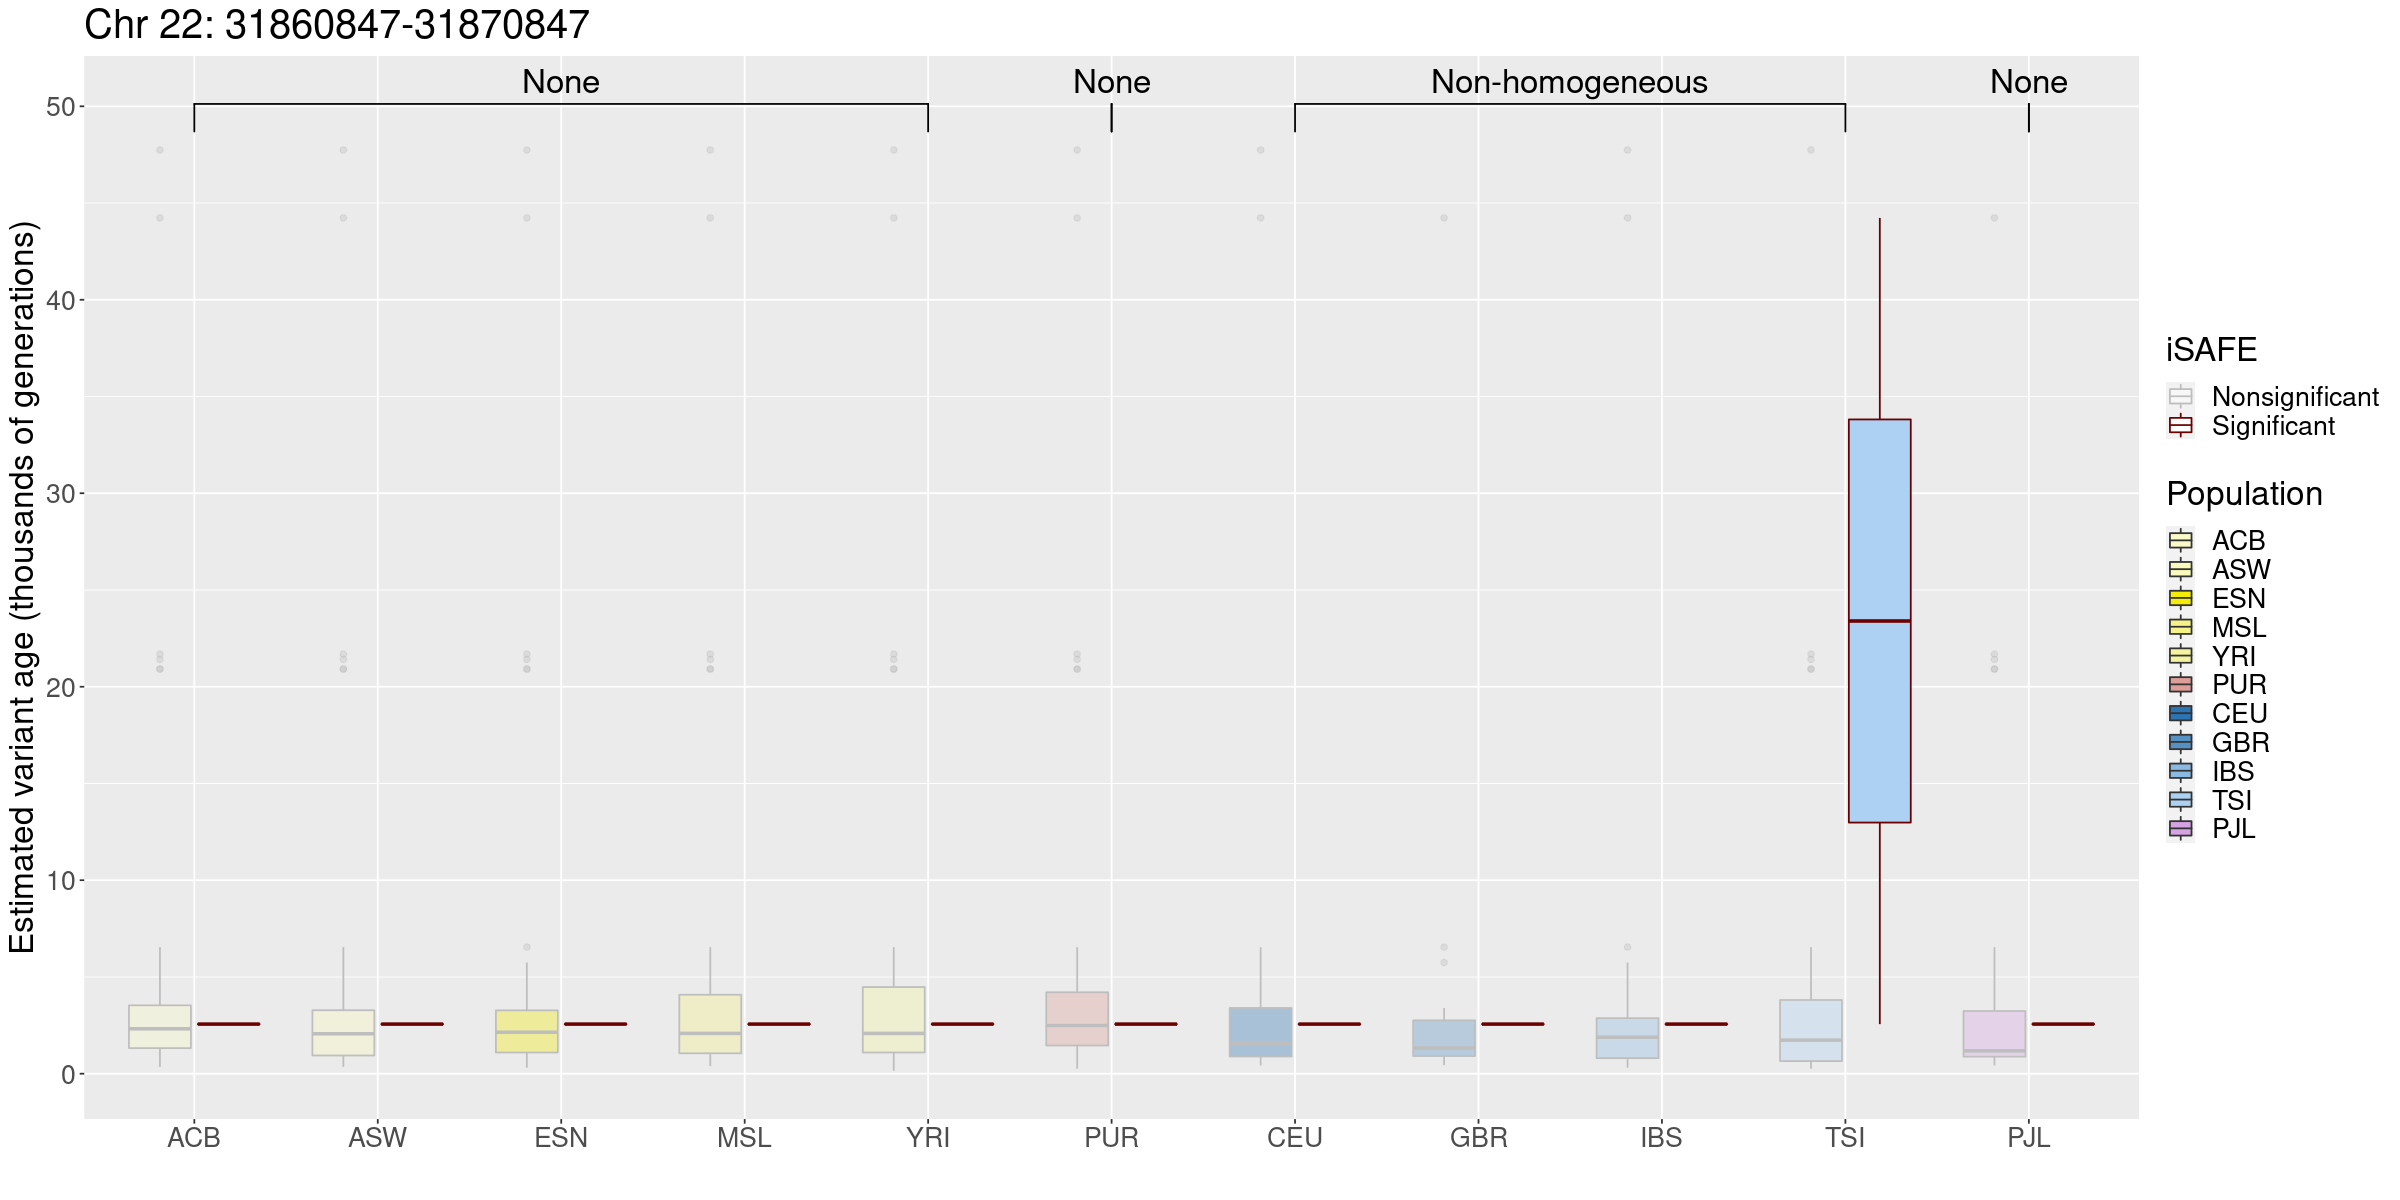

In [23]:
diferencia_edats(22, 31860847, 31870847) #EIF4ENIF1,DRG1

Warning message in data.frame(x = c(min(comp[1], comp[2]), min(comp[1], comp[2]), :
“row names were found from a short variable and have been discarded”
Warning message in data.frame(x = c(min(comp[1], comp[2]), min(comp[1], comp[2]), :
“row names were found from a short variable and have been discarded”
Warning message in data.frame(x = c(min(comp[1], comp[2]), min(comp[1], comp[2]), :
“row names were found from a short variable and have been discarded”
Warning message in data.frame(x = c(min(comp[1], comp[2]), min(comp[1], comp[2]), :
“row names were found from a short variable and have been discarded”


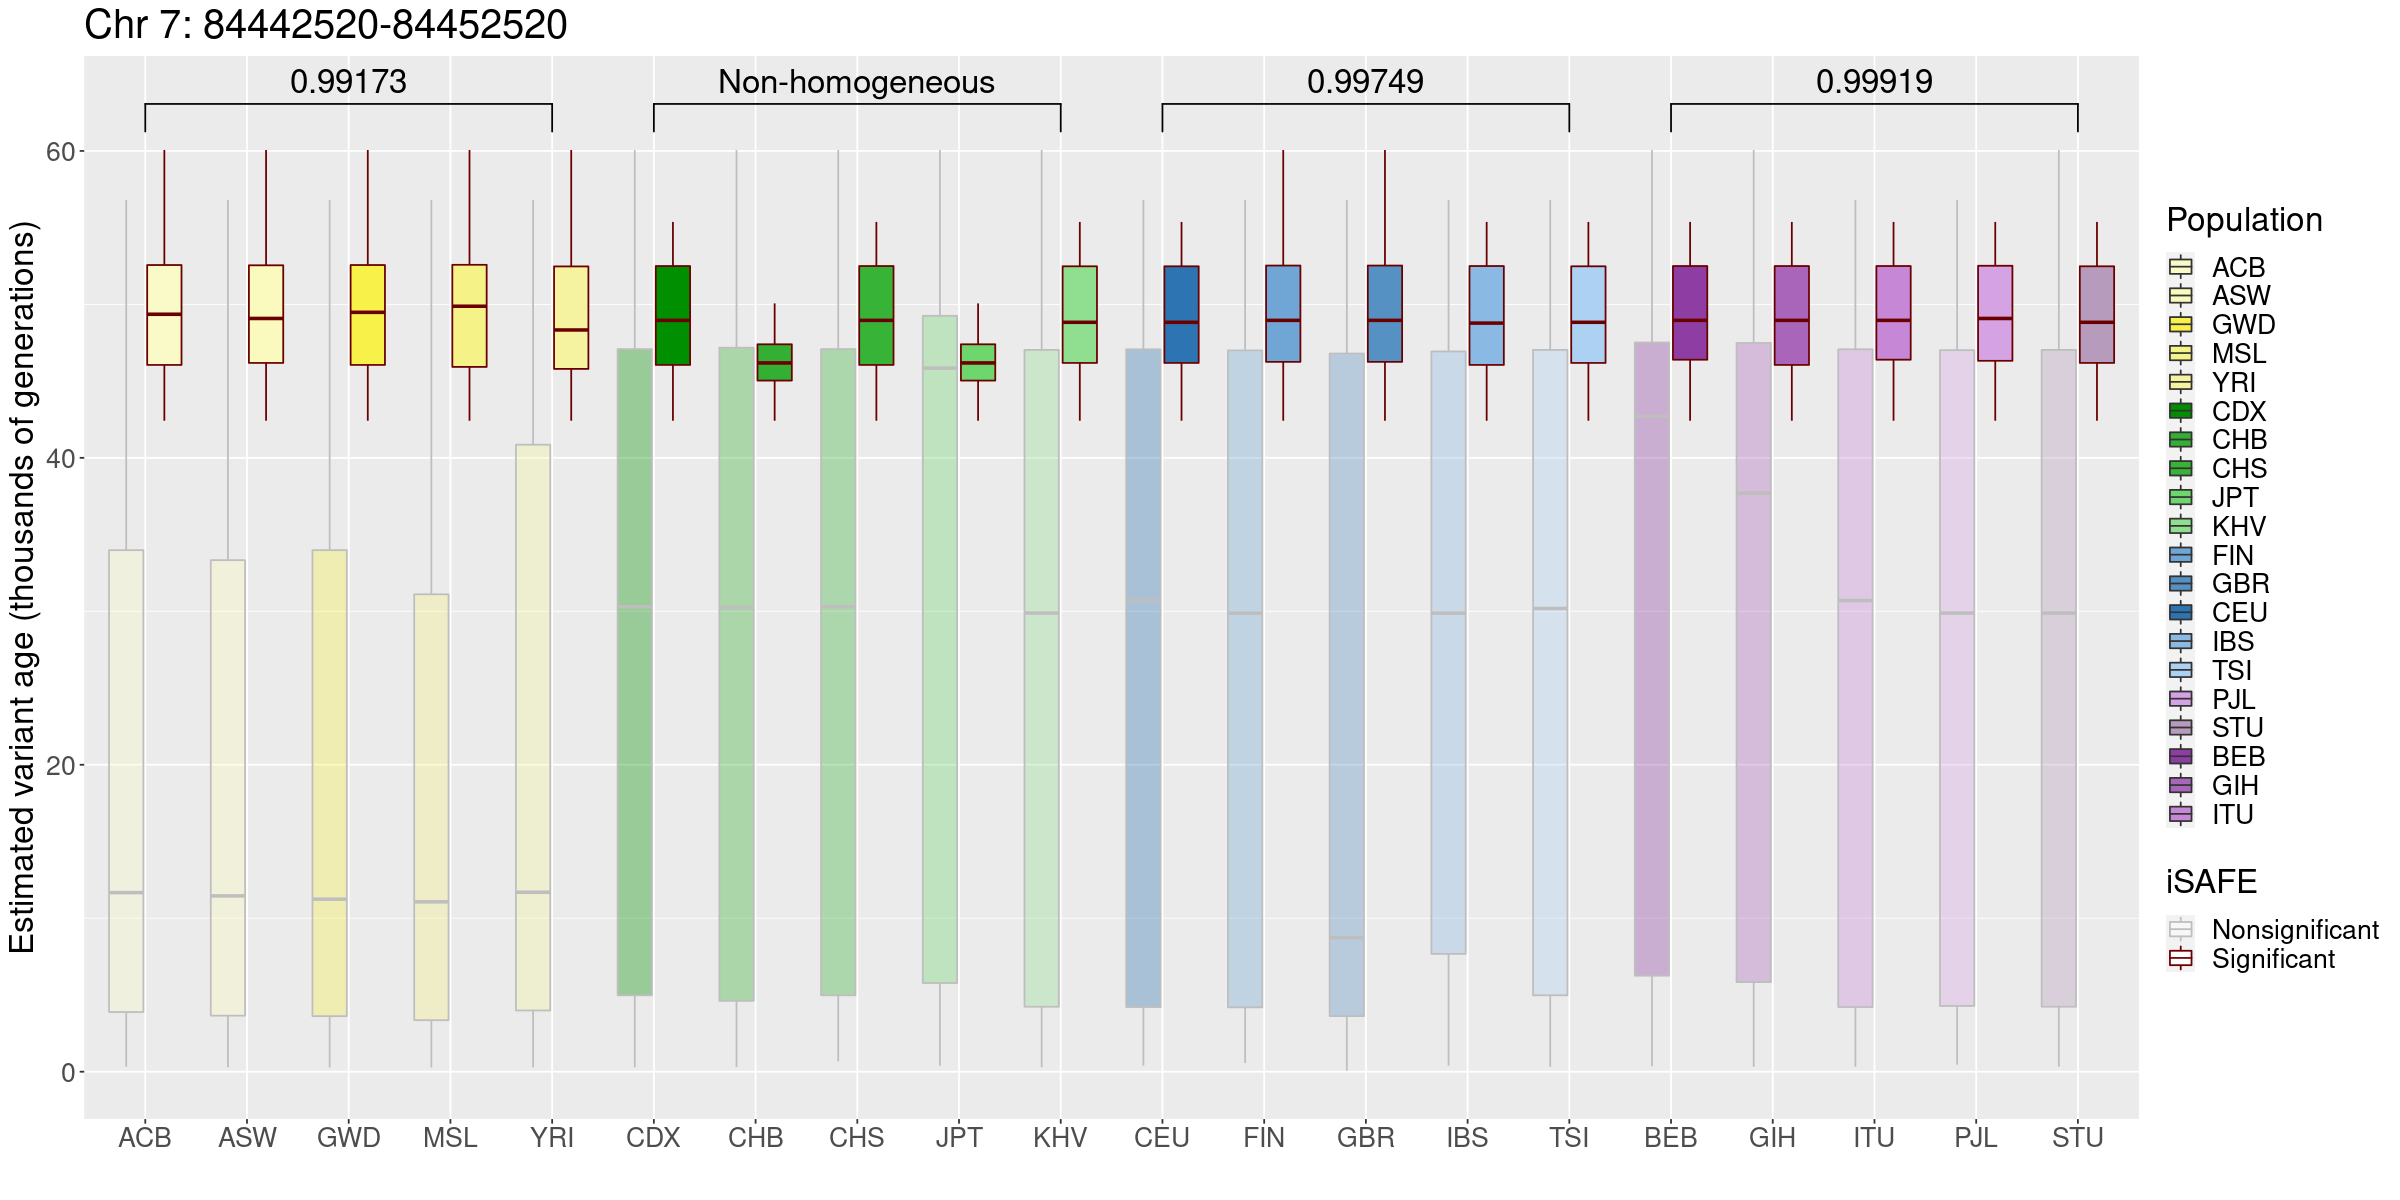

In [24]:
diferencia_edats(7, 84442520, 84452520, AMR = FALSE) #nonCoding43263

Warning message in data.frame(x = c(min(comp[1], comp[2]), min(comp[1], comp[2]), :
“row names were found from a short variable and have been discarded”
Warning message in data.frame(x = c(min(comp[1], comp[2]), min(comp[1], comp[2]), :
“row names were found from a short variable and have been discarded”
Warning message in data.frame(x = c(min(comp[1], comp[2]), min(comp[1], comp[2]), :
“row names were found from a short variable and have been discarded”
Warning message in data.frame(x = c(min(comp[1], comp[2]), min(comp[1], comp[2]), :
“row names were found from a short variable and have been discarded”


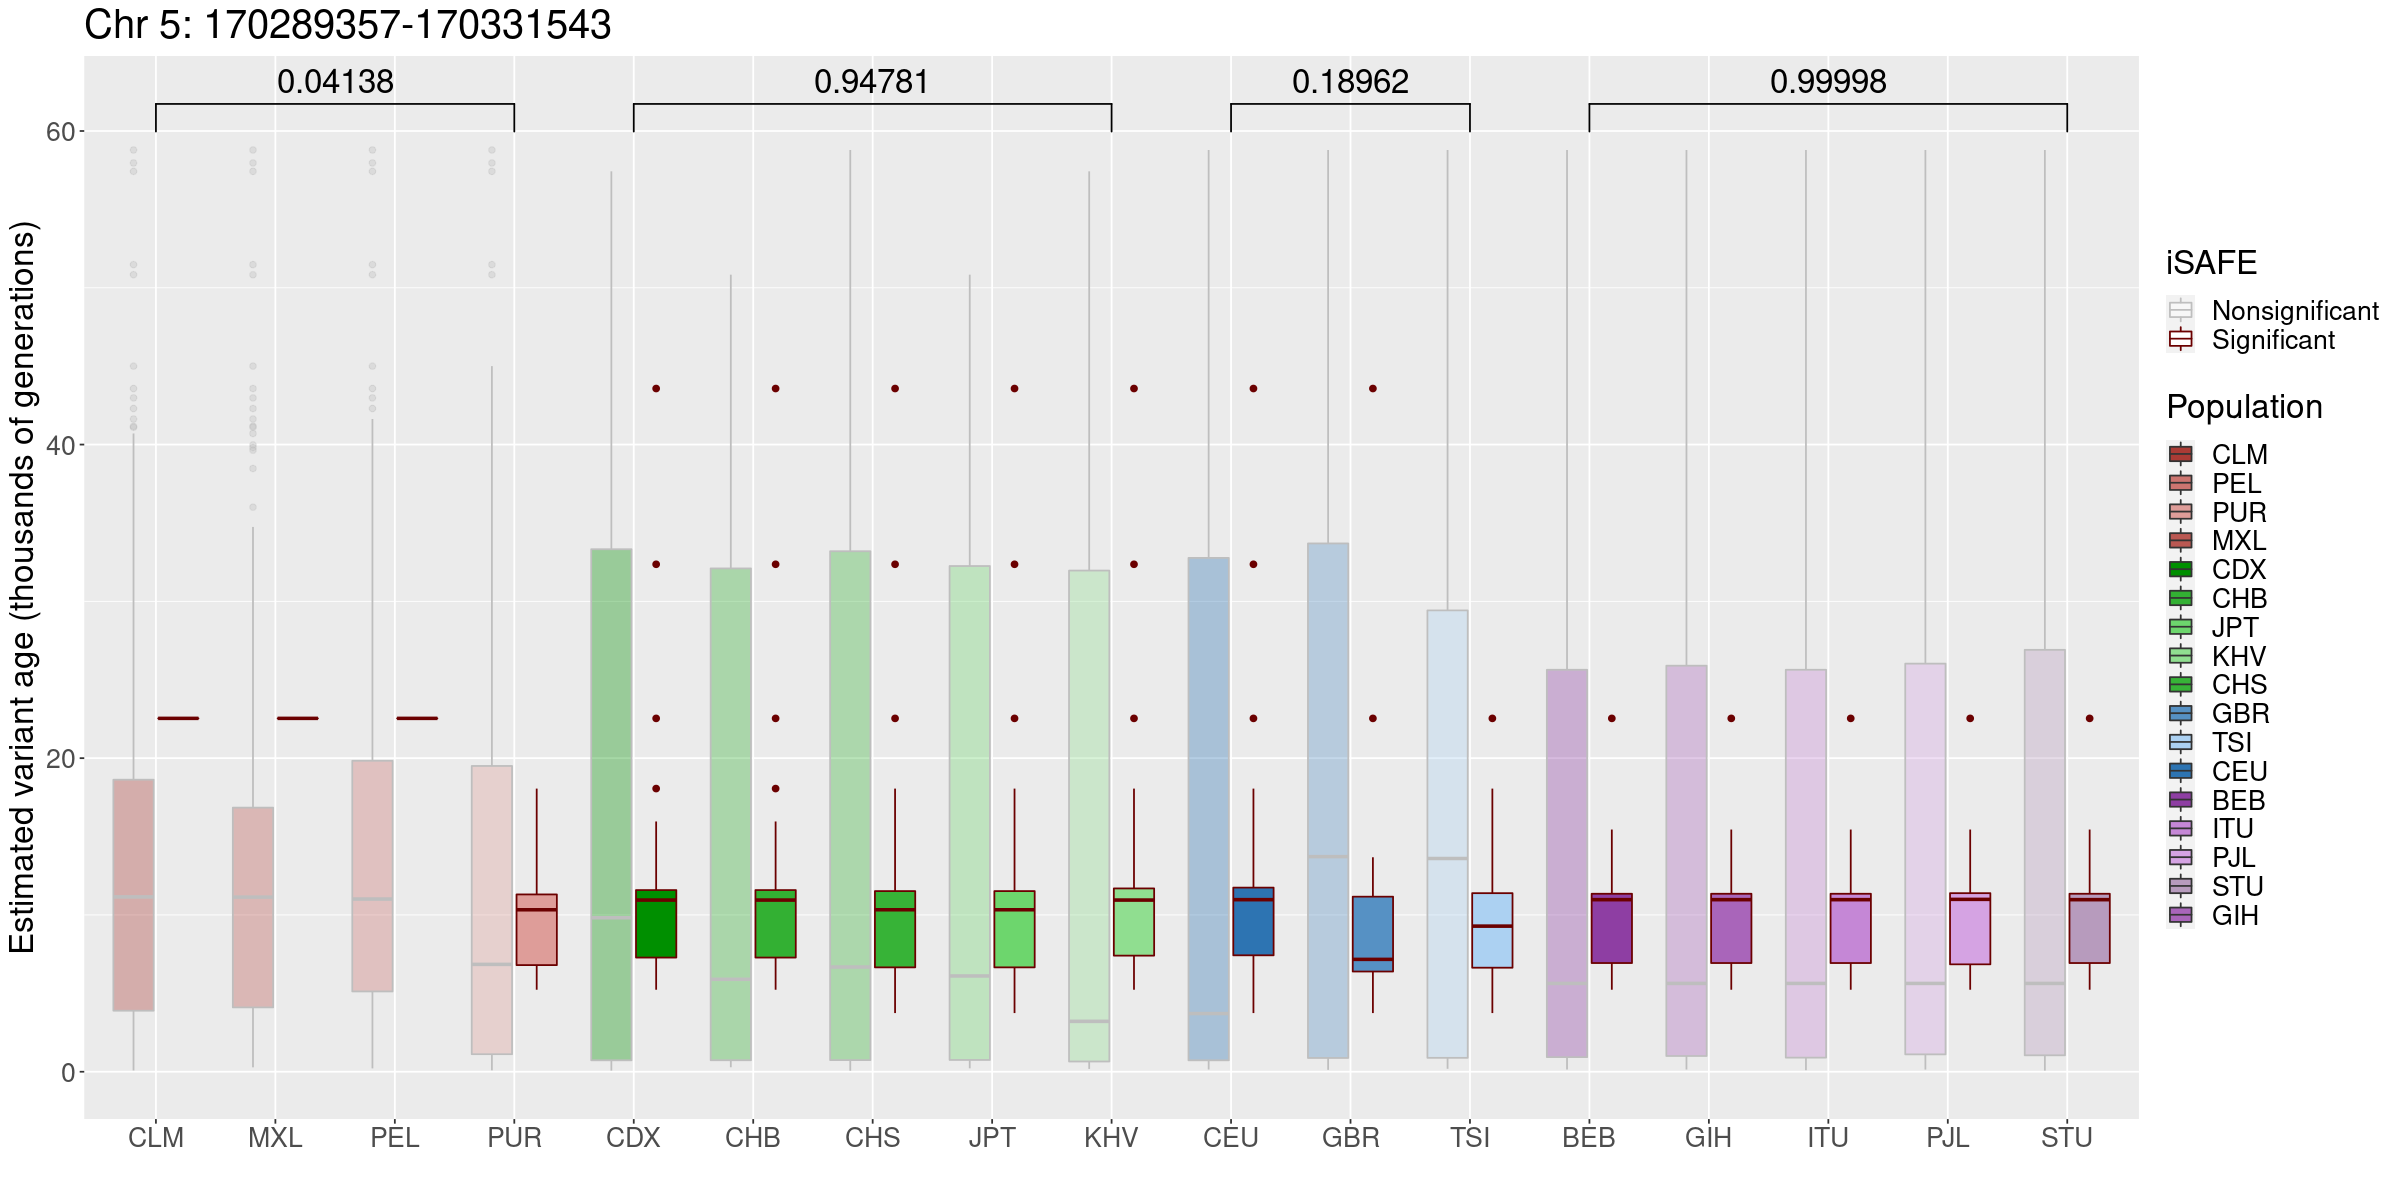

In [25]:
diferencia_edats(5, 170289357, 170331543) #RANBP17

Warning message in data.frame(x = c(min(comp[1], comp[2]), min(comp[1], comp[2]), :
“row names were found from a short variable and have been discarded”
Warning message in data.frame(x = c(min(comp[1], comp[2]), min(comp[1], comp[2]), :
“row names were found from a short variable and have been discarded”
Warning message in data.frame(x = c(min(comp[1], comp[2]), min(comp[1], comp[2]), :
“row names were found from a short variable and have been discarded”
Warning message in data.frame(x = c(min(comp[1], comp[2]), min(comp[1], comp[2]), :
“row names were found from a short variable and have been discarded”


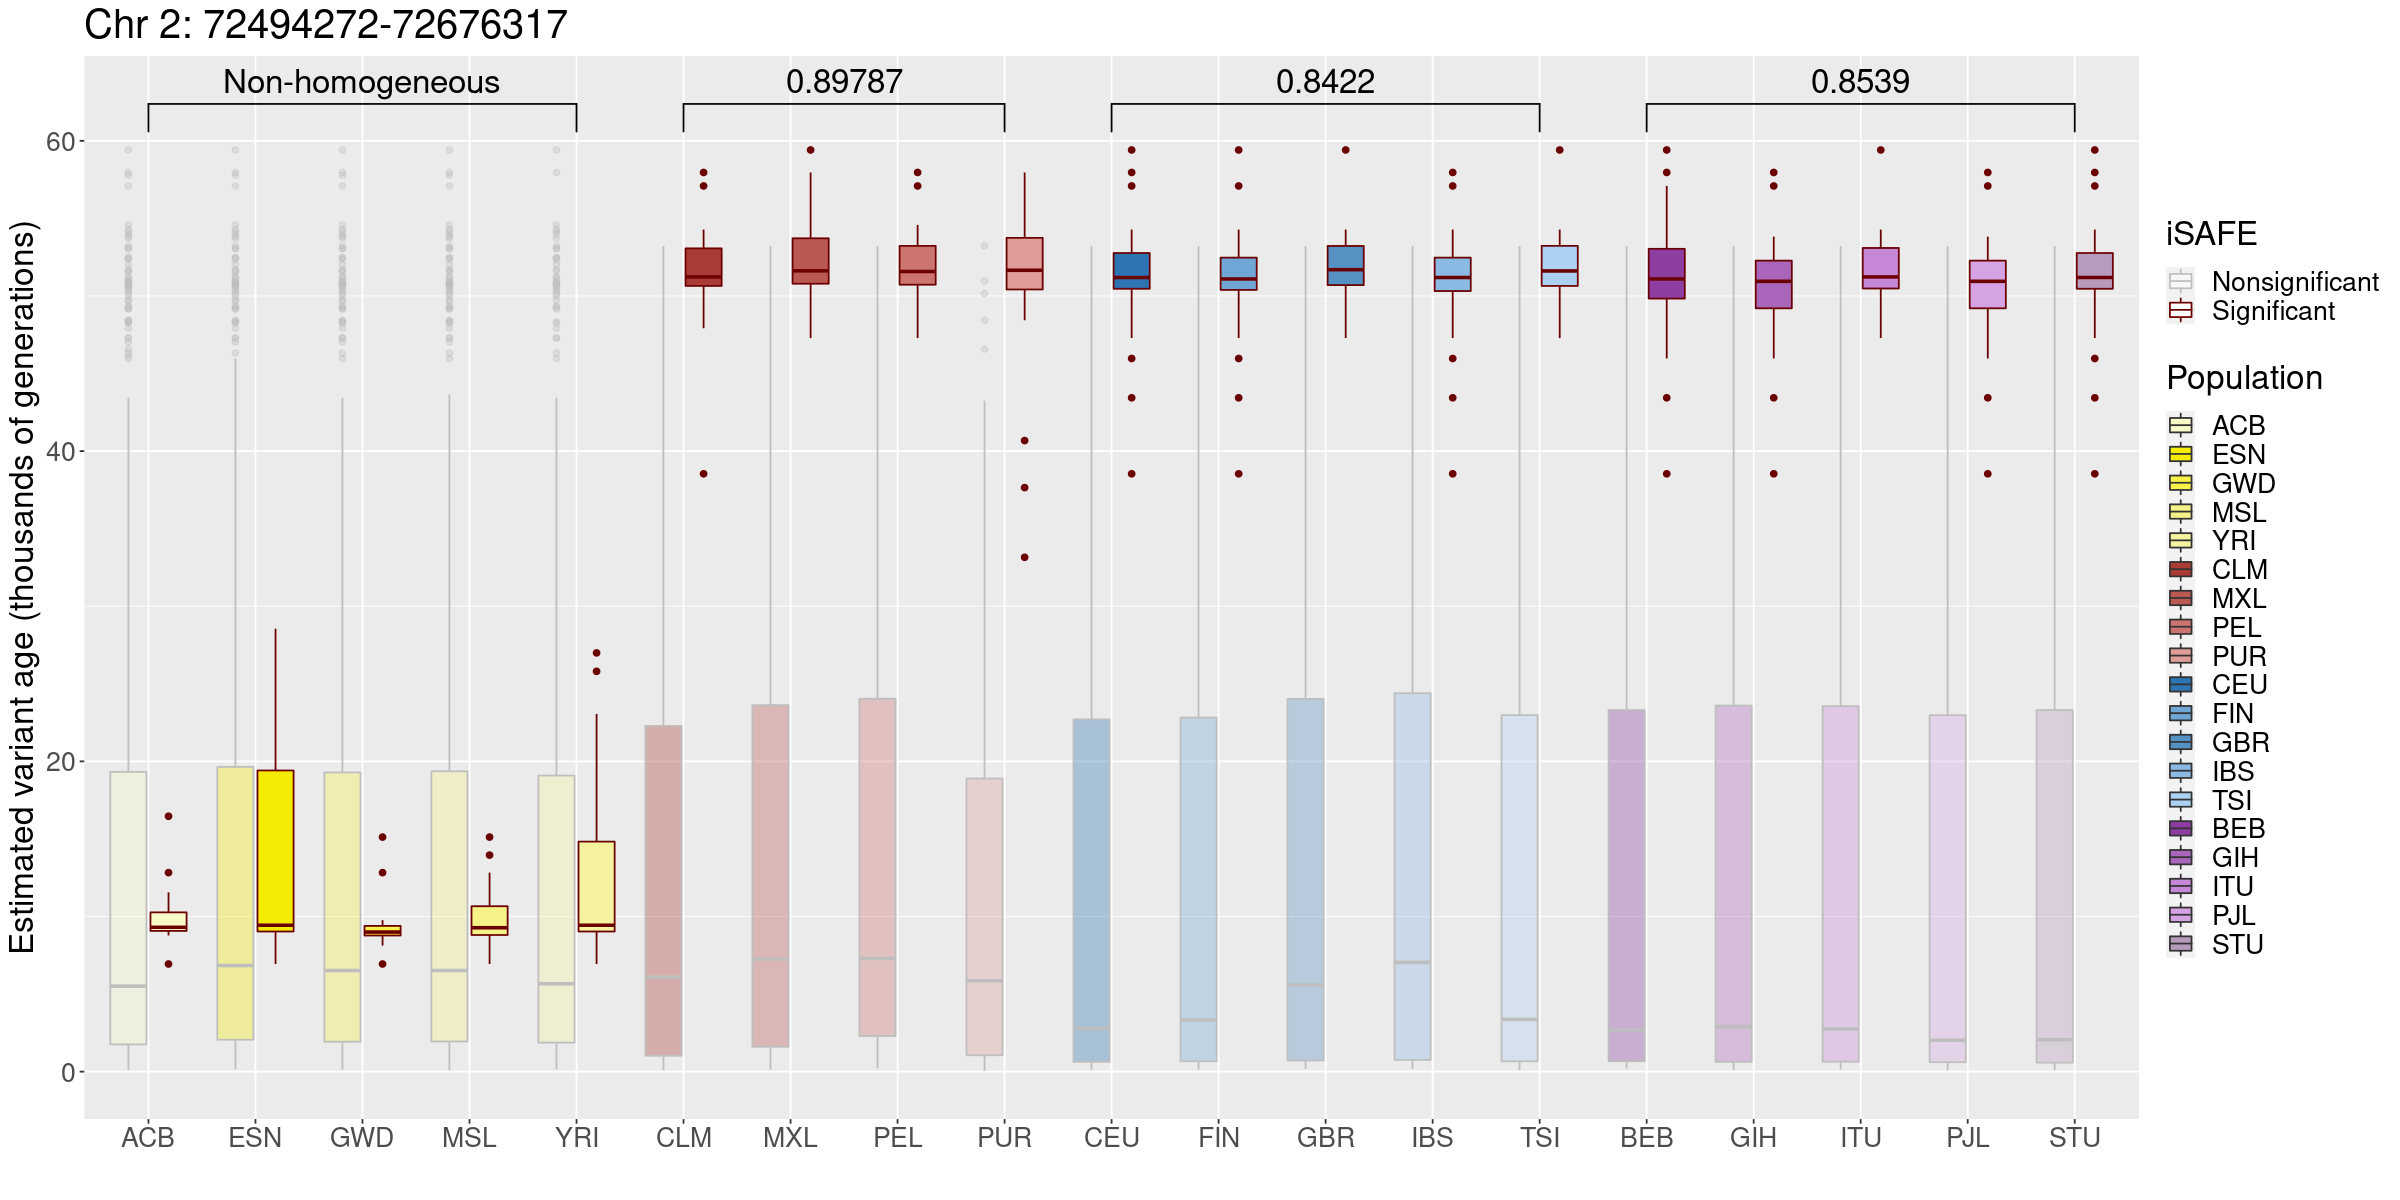

In [26]:
diferencia_edats(2, 72494272, 72676317) #EXOC6B

Warning message in data.frame(x = c(min(comp[1], comp[2]), min(comp[1], comp[2]), :
“row names were found from a short variable and have been discarded”
Warning message in data.frame(x = c(min(comp[1], comp[2]), min(comp[1], comp[2]), :
“row names were found from a short variable and have been discarded”
Warning message in data.frame(x = c(min(comp[1], comp[2]), min(comp[1], comp[2]), :
“row names were found from a short variable and have been discarded”
Warning message in data.frame(x = c(min(comp[1], comp[2]), min(comp[1], comp[2]), :
“row names were found from a short variable and have been discarded”


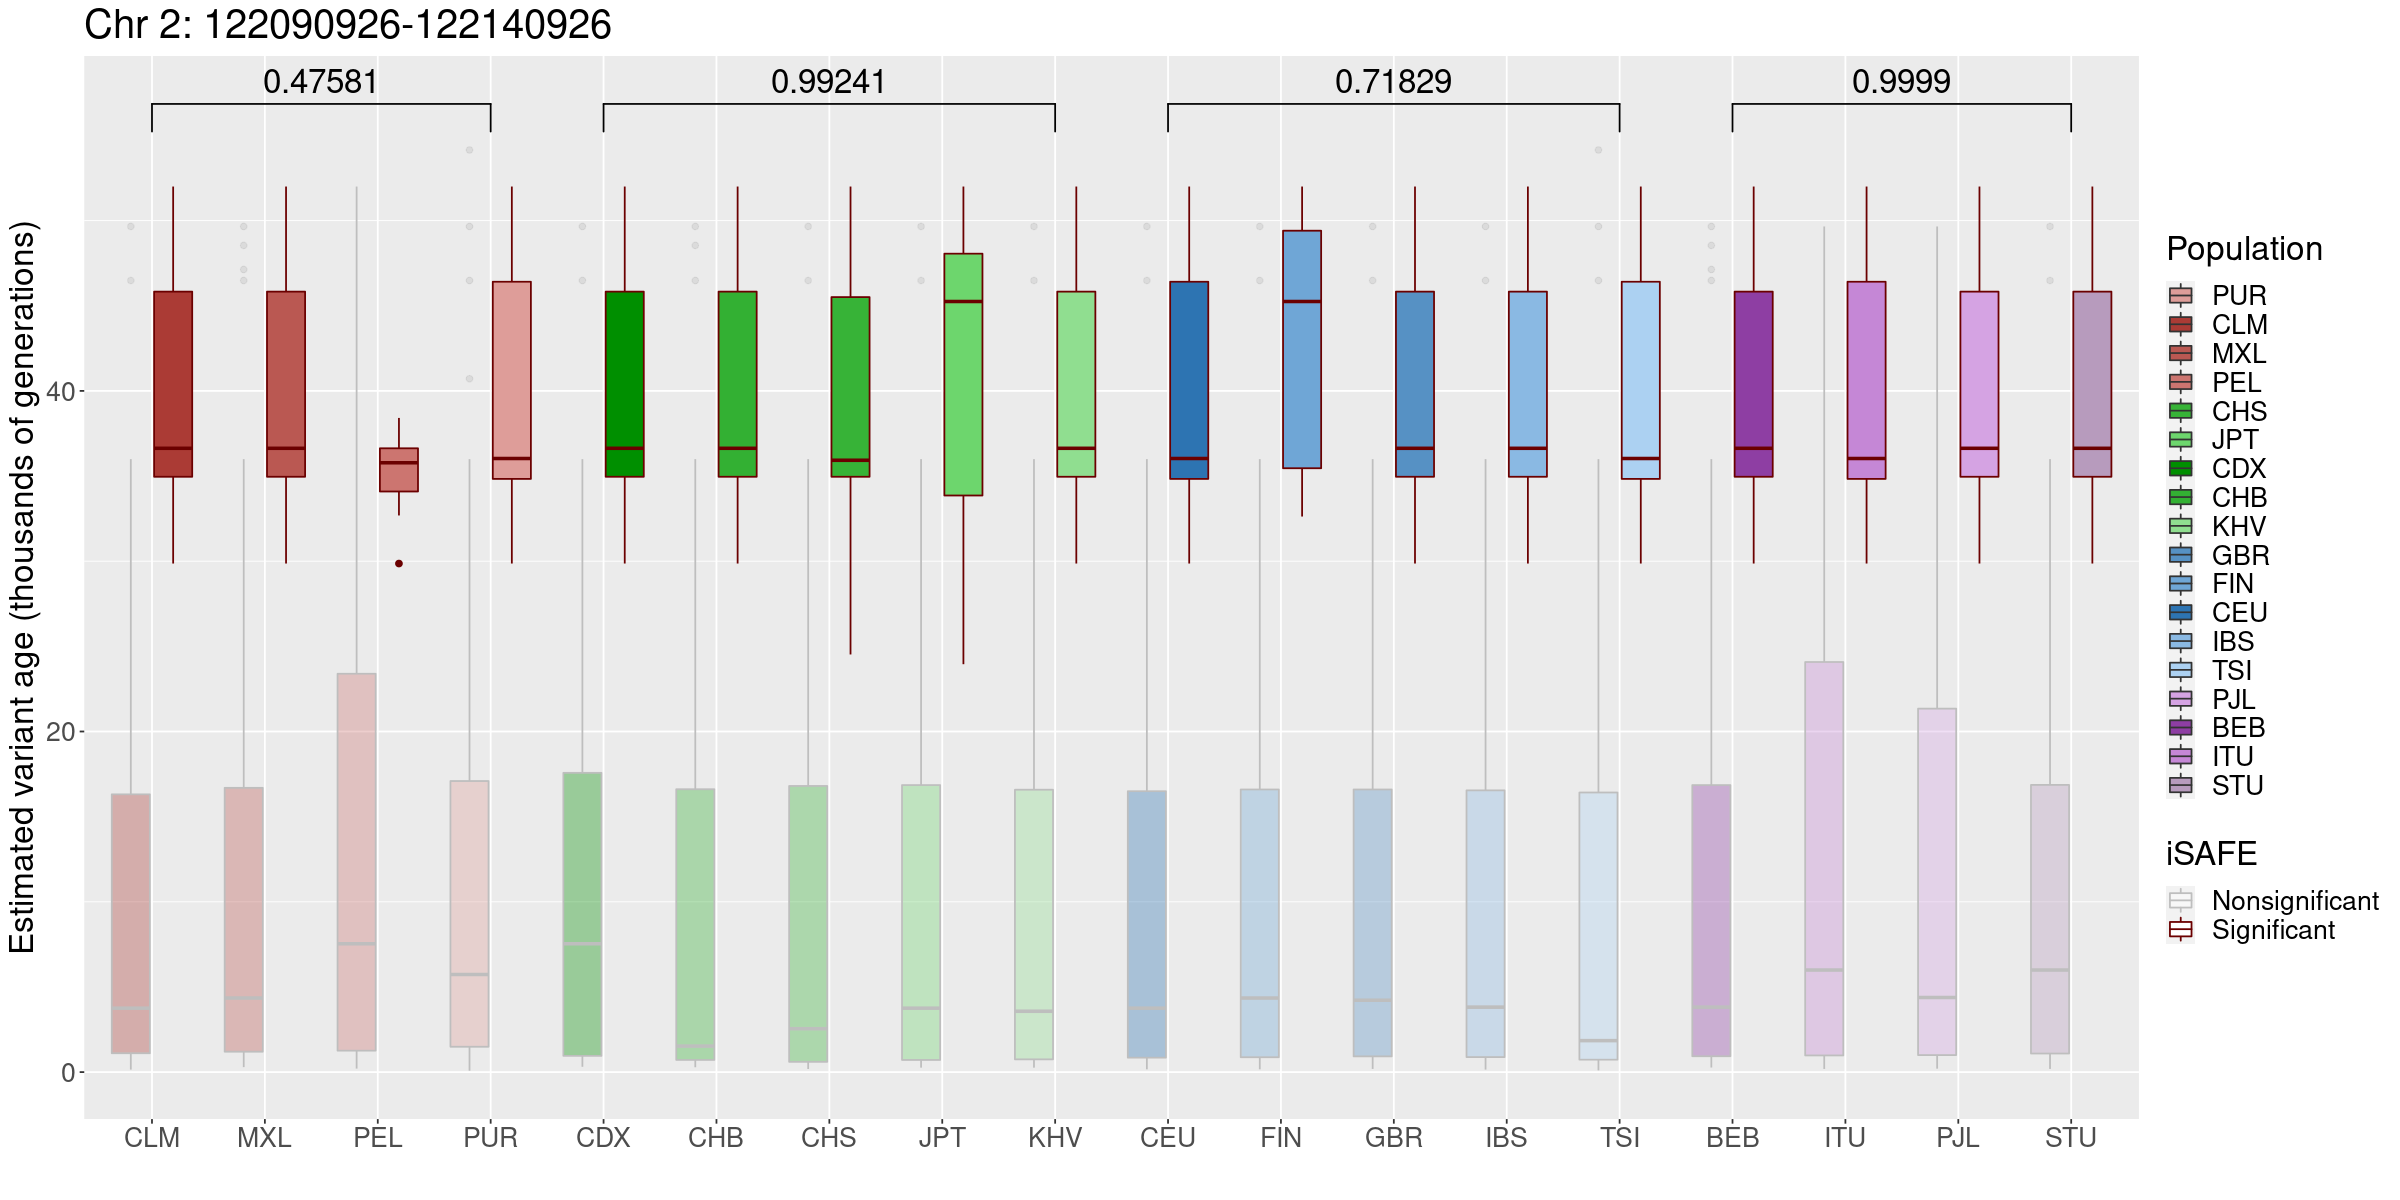

In [27]:
diferencia_edats(2, 122090926, 122140926) #CLASP1

Warning message in data.frame(x = c(min(comp[1], comp[2]), min(comp[1], comp[2]), :
“row names were found from a short variable and have been discarded”
Warning message in data.frame(x = c(min(comp[1], comp[2]), min(comp[1], comp[2]), :
“row names were found from a short variable and have been discarded”
Warning message in data.frame(x = c(min(comp[1], comp[2]), min(comp[1], comp[2]), :
“row names were found from a short variable and have been discarded”


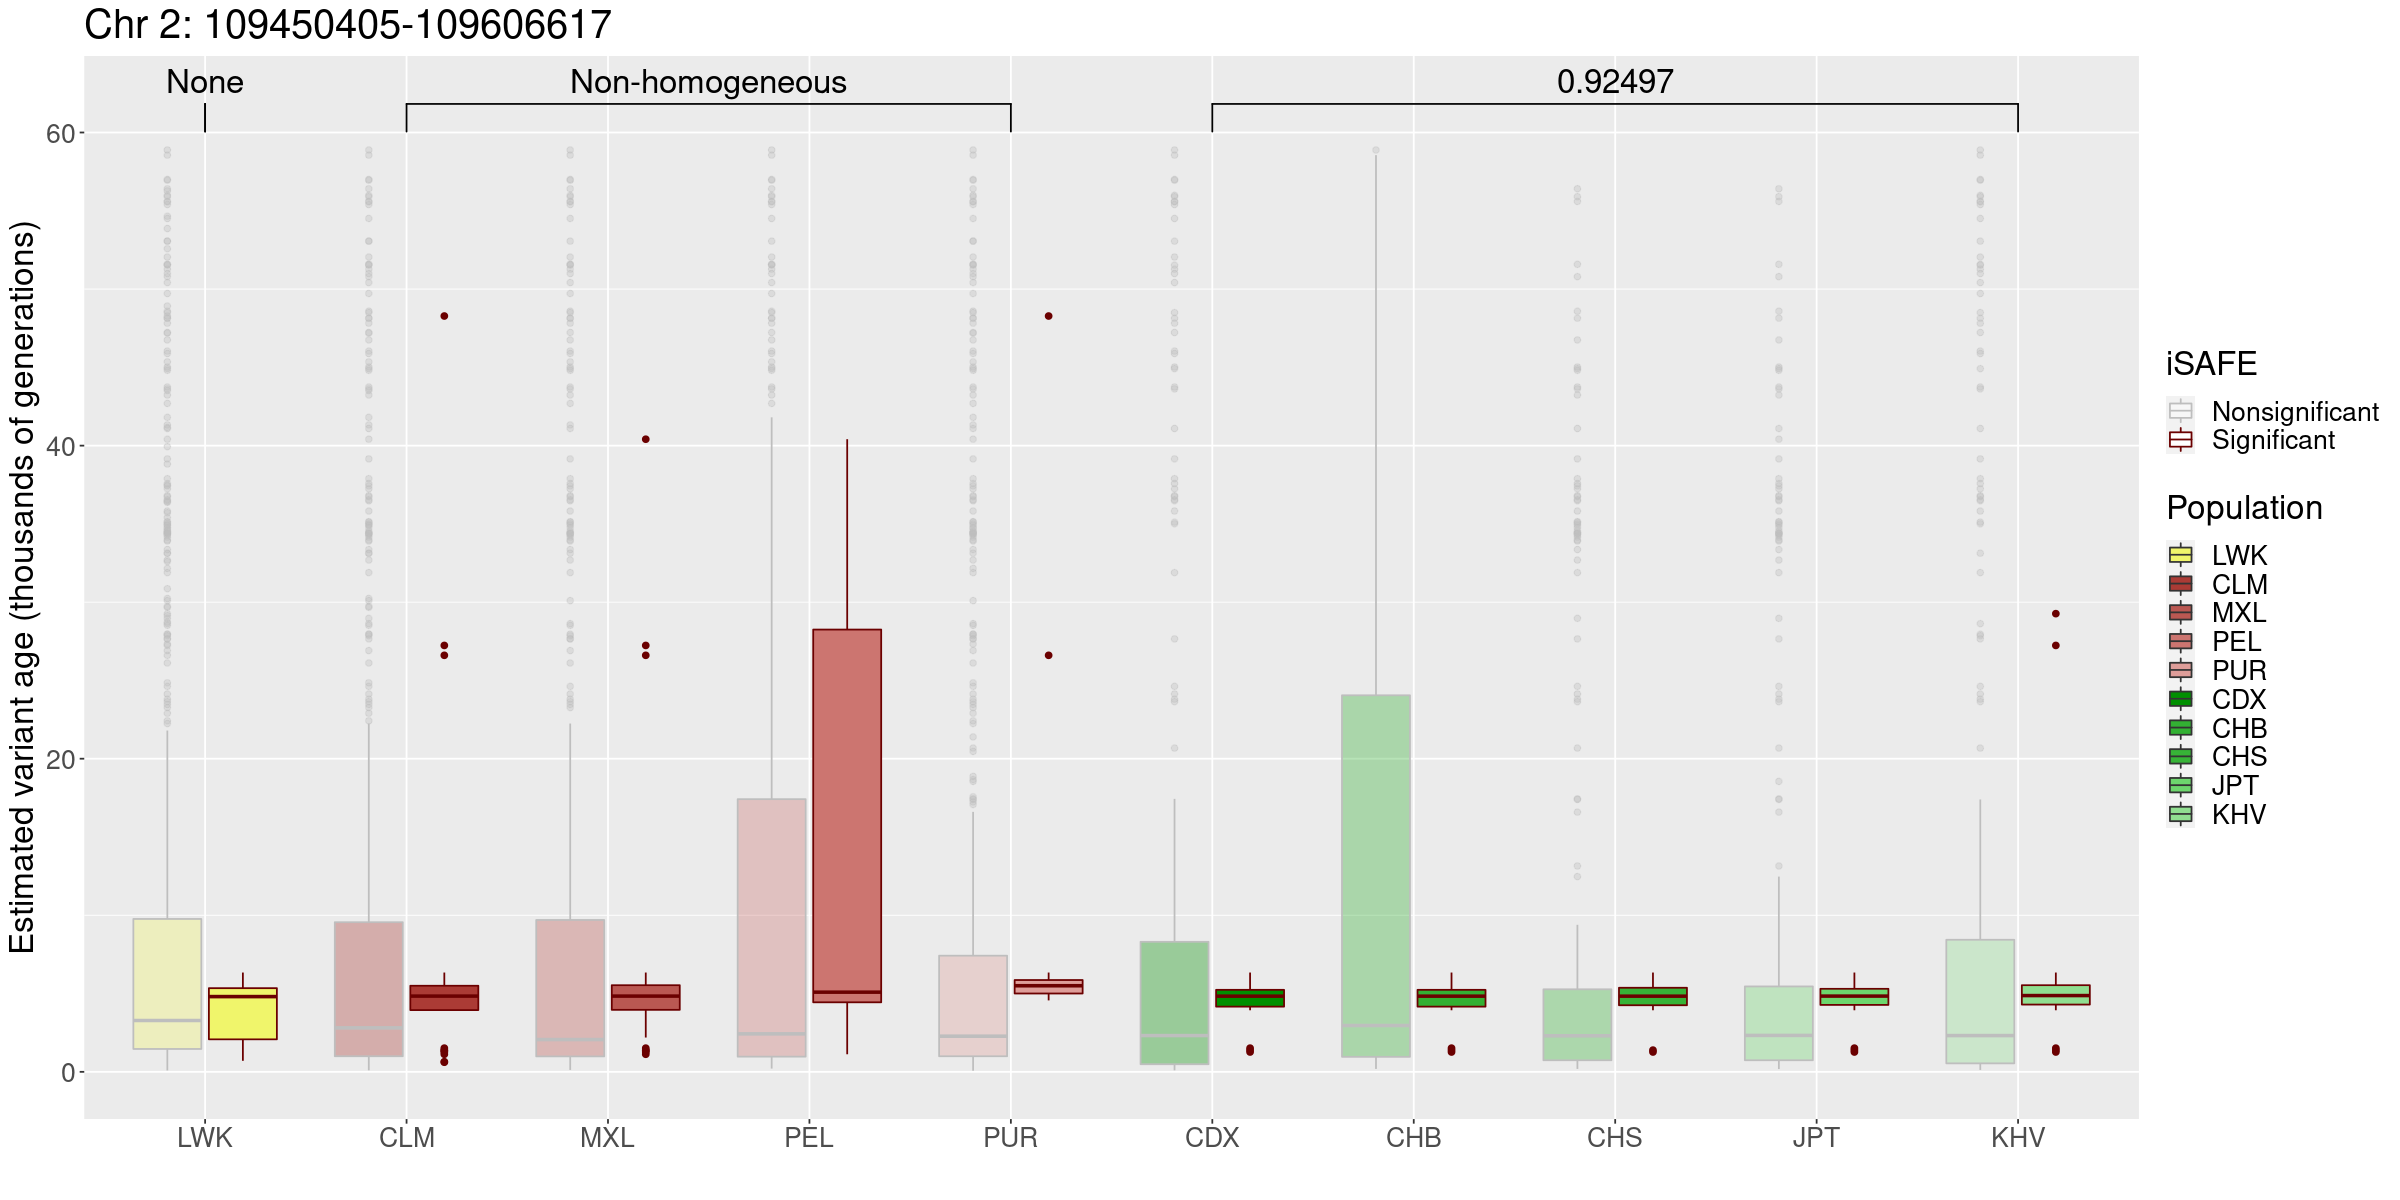

In [4]:
diferencia_edats(2, 109450405, 109606617) #EDAR,CCDC138

Warning message in data.frame(x = c(min(comp[1], comp[2]), min(comp[1], comp[2]), :
“row names were found from a short variable and have been discarded”
Warning message in data.frame(x = c(min(comp[1], comp[2]), min(comp[1], comp[2]), :
“row names were found from a short variable and have been discarded”
Warning message in data.frame(x = c(min(comp[1], comp[2]), min(comp[1], comp[2]), :
“row names were found from a short variable and have been discarded”
Warning message in data.frame(x = c(min(comp[1], comp[2]), min(comp[1], comp[2]), :
“row names were found from a short variable and have been discarded”


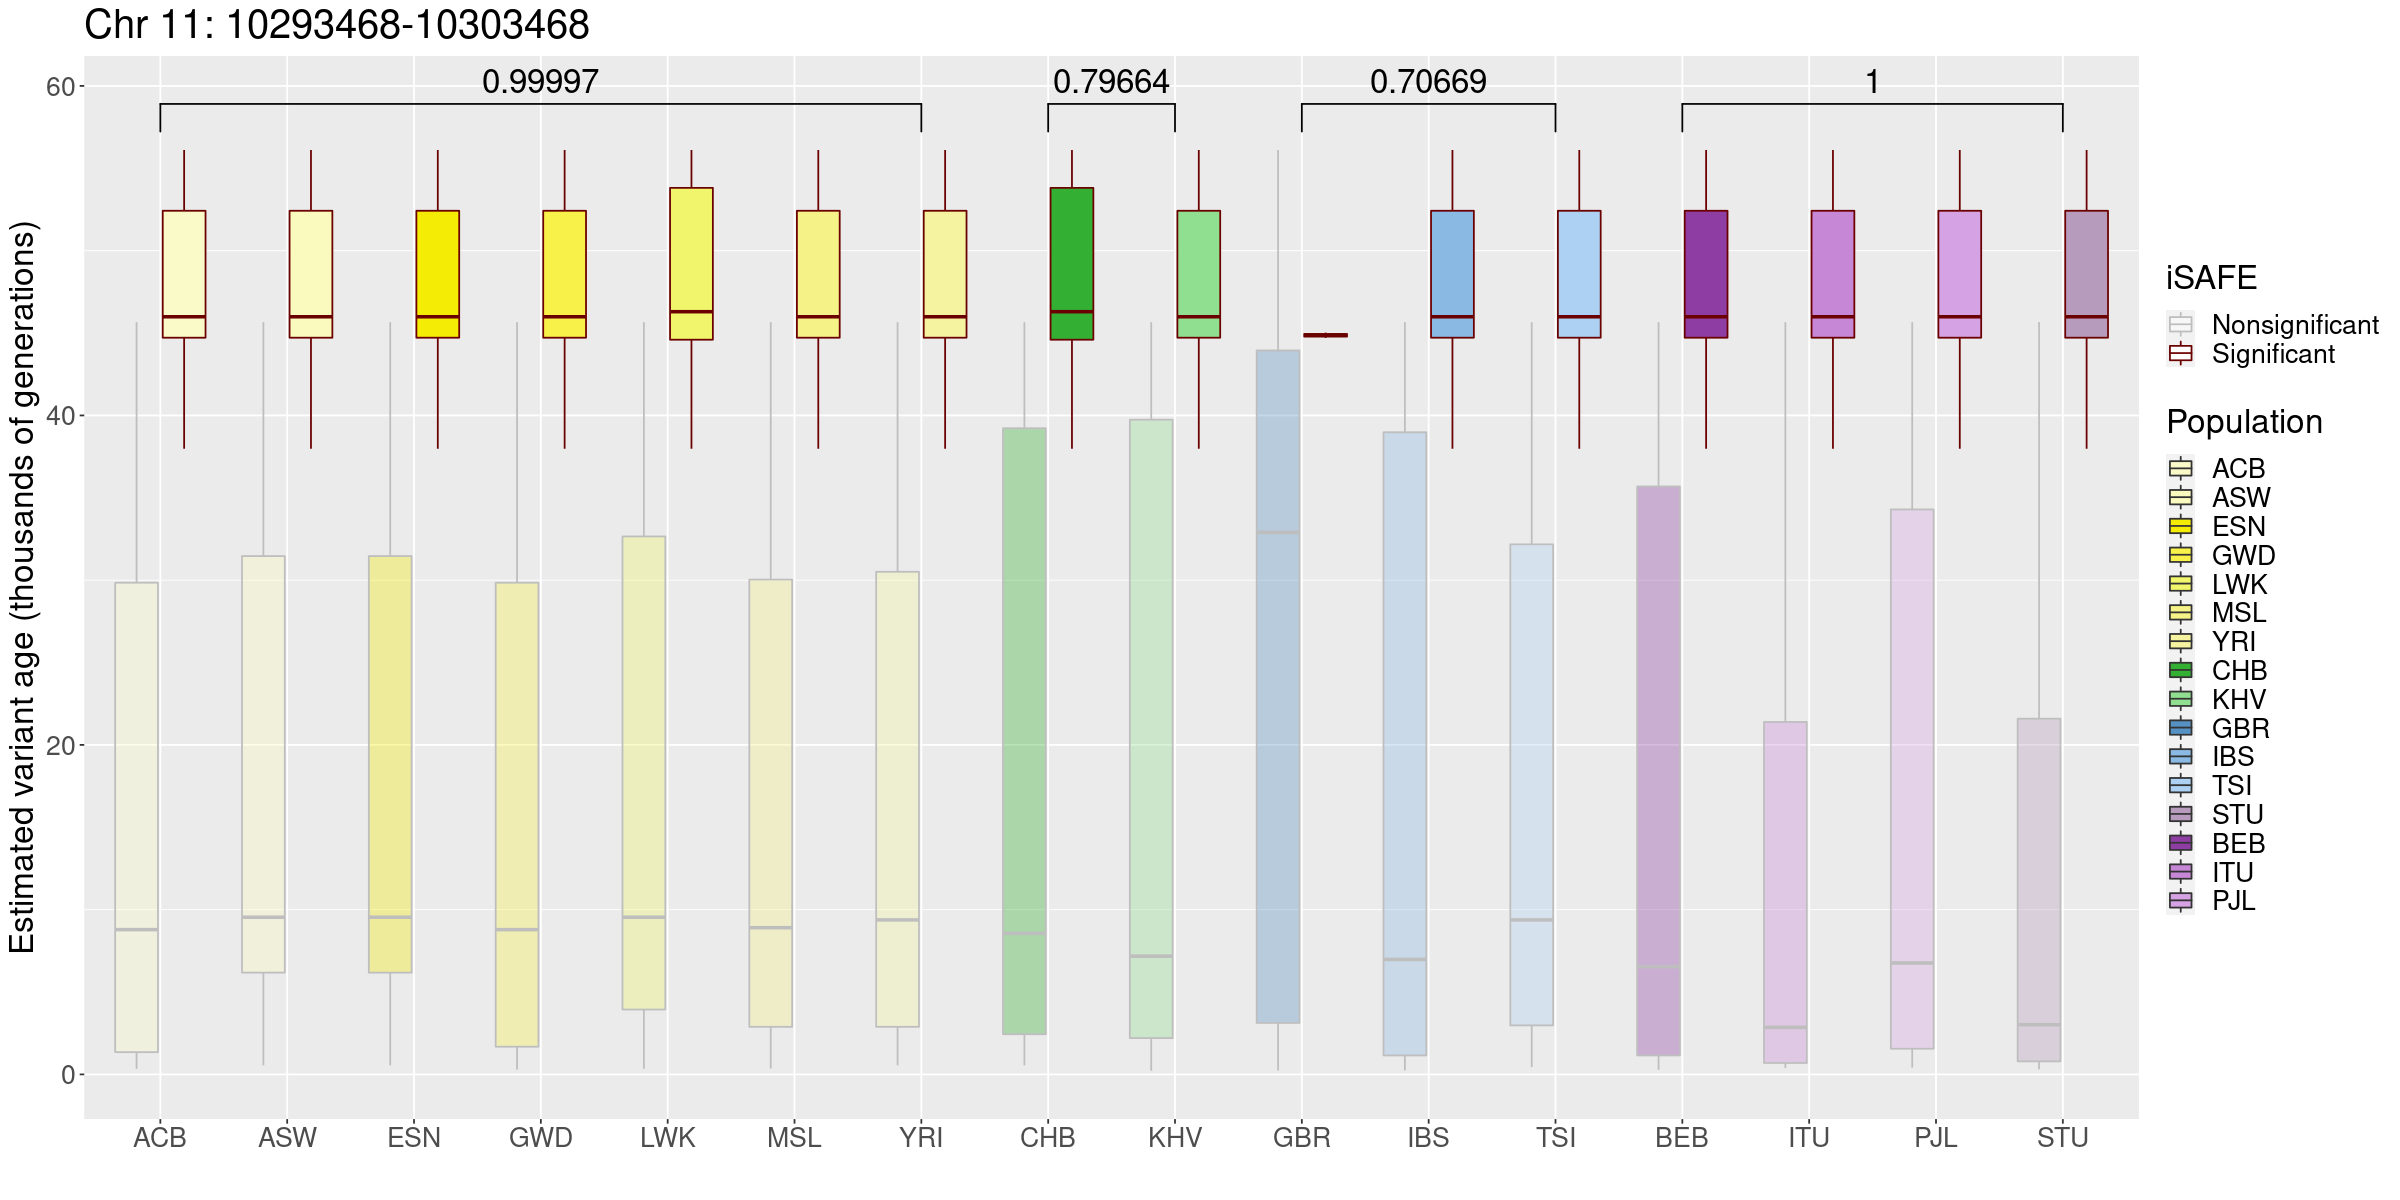

In [39]:
diferencia_edats(11, 10293468, 10303468, AMR = FALSE) #SBF2

Warning message in data.frame(x = c(min(comp[1], comp[2]), min(comp[1], comp[2]), :
“row names were found from a short variable and have been discarded”
Warning message in data.frame(x = c(min(comp[1], comp[2]), min(comp[1], comp[2]), :
“row names were found from a short variable and have been discarded”
Warning message in data.frame(x = c(min(comp[1], comp[2]), min(comp[1], comp[2]), :
“row names were found from a short variable and have been discarded”


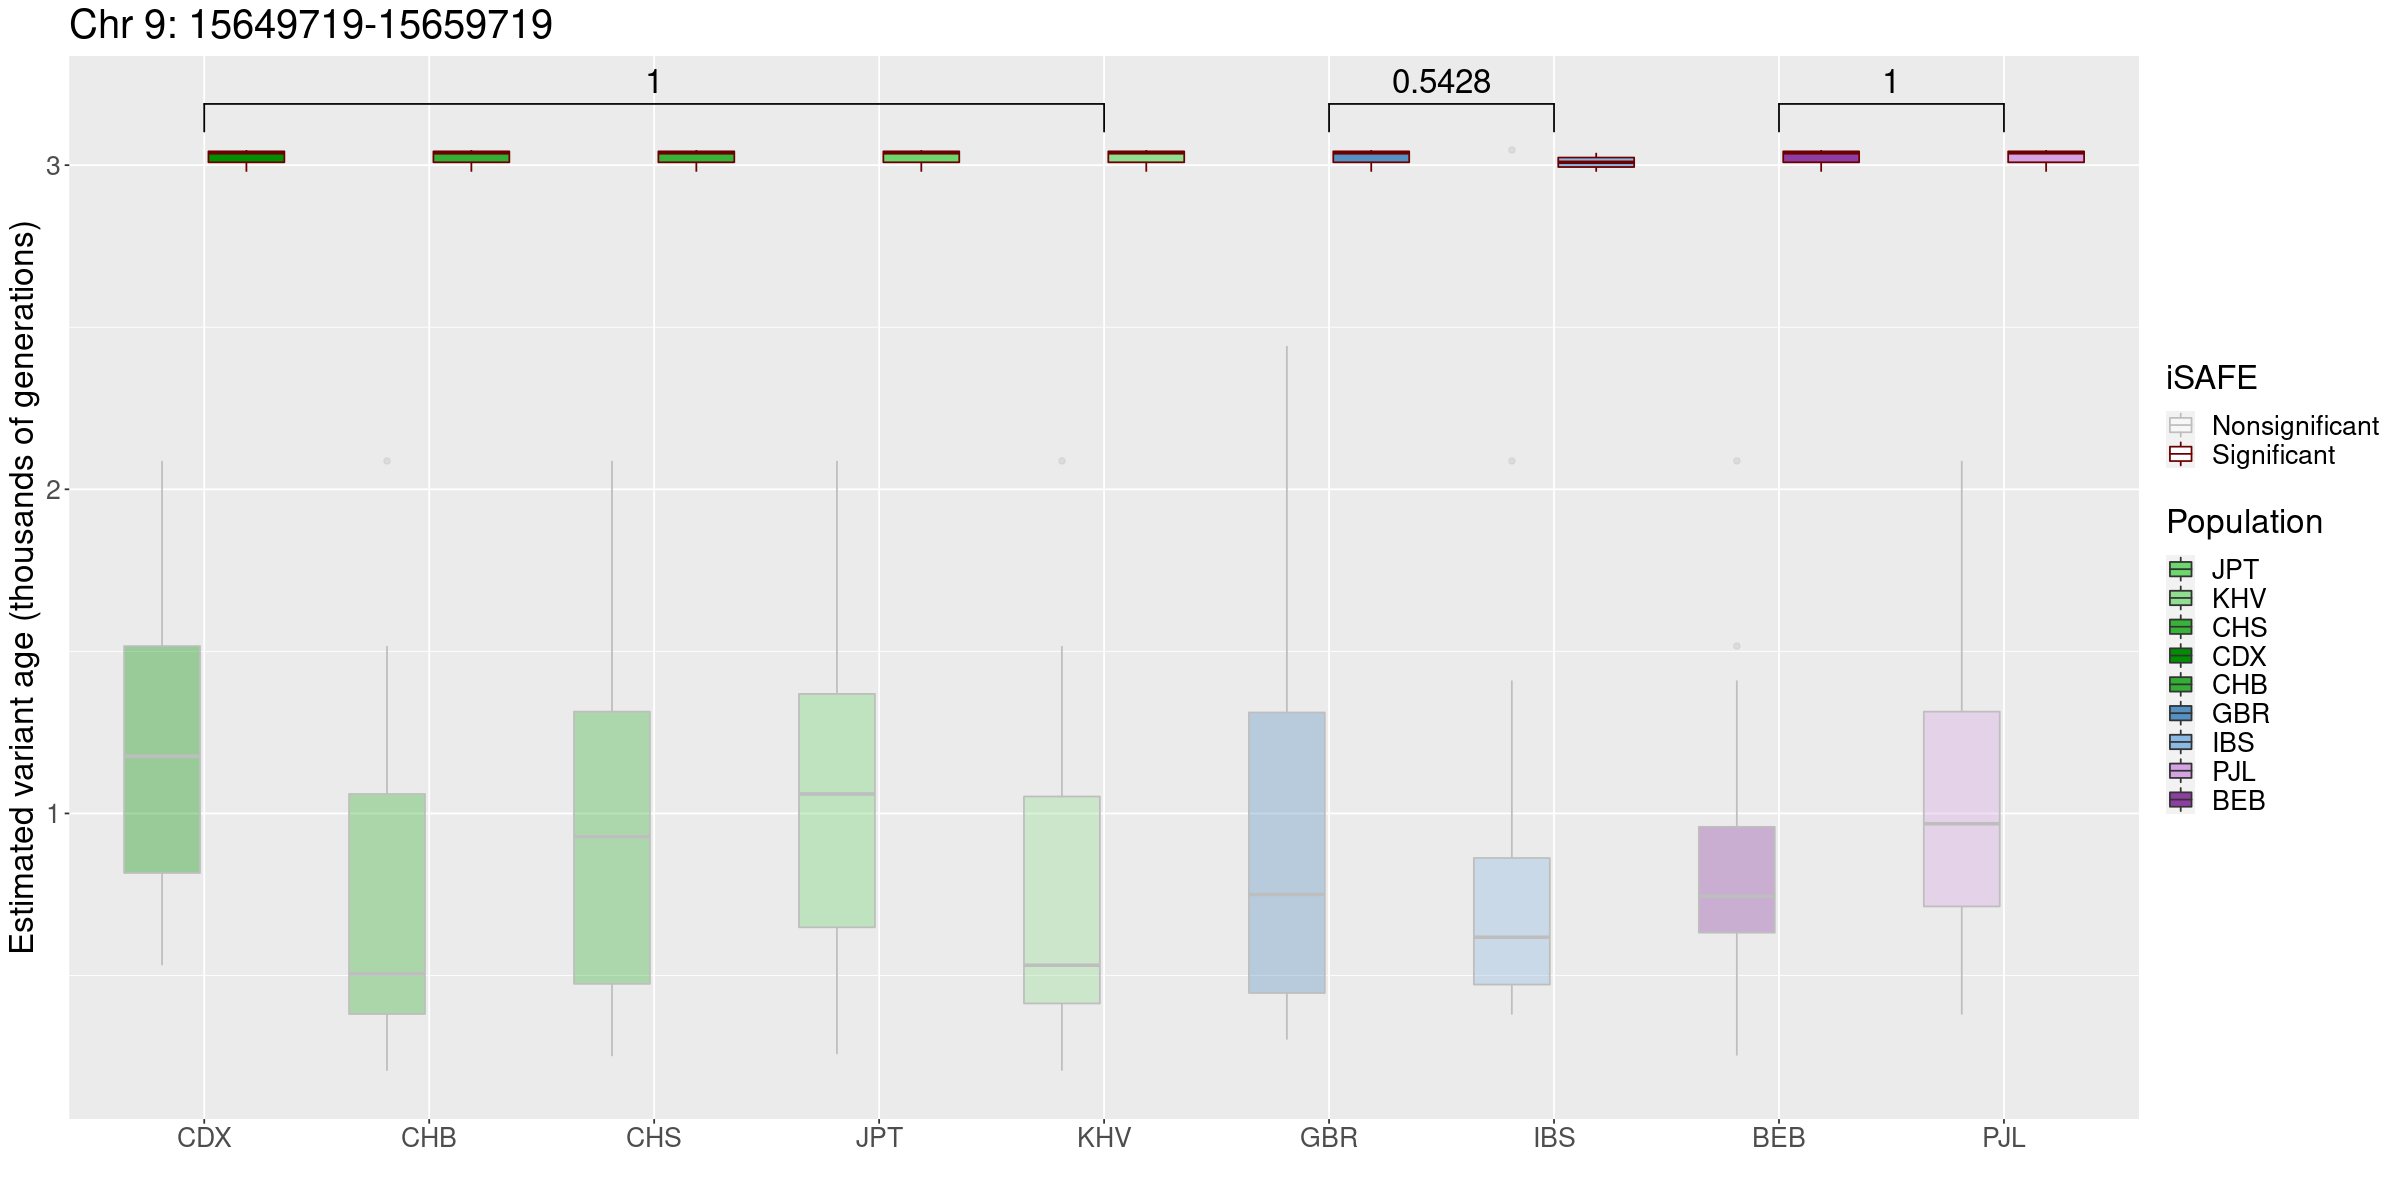

In [30]:
diferencia_edats(9, 15649719, 15659719, AMR = FALSE) #CCDC171

Warning message in data.frame(x = c(min(comp[1], comp[2]), min(comp[1], comp[2]), :
“row names were found from a short variable and have been discarded”
Warning message in data.frame(x = c(min(comp[1], comp[2]), min(comp[1], comp[2]), :
“row names were found from a short variable and have been discarded”
Warning message in data.frame(x = c(min(comp[1], comp[2]), min(comp[1], comp[2]), :
“row names were found from a short variable and have been discarded”


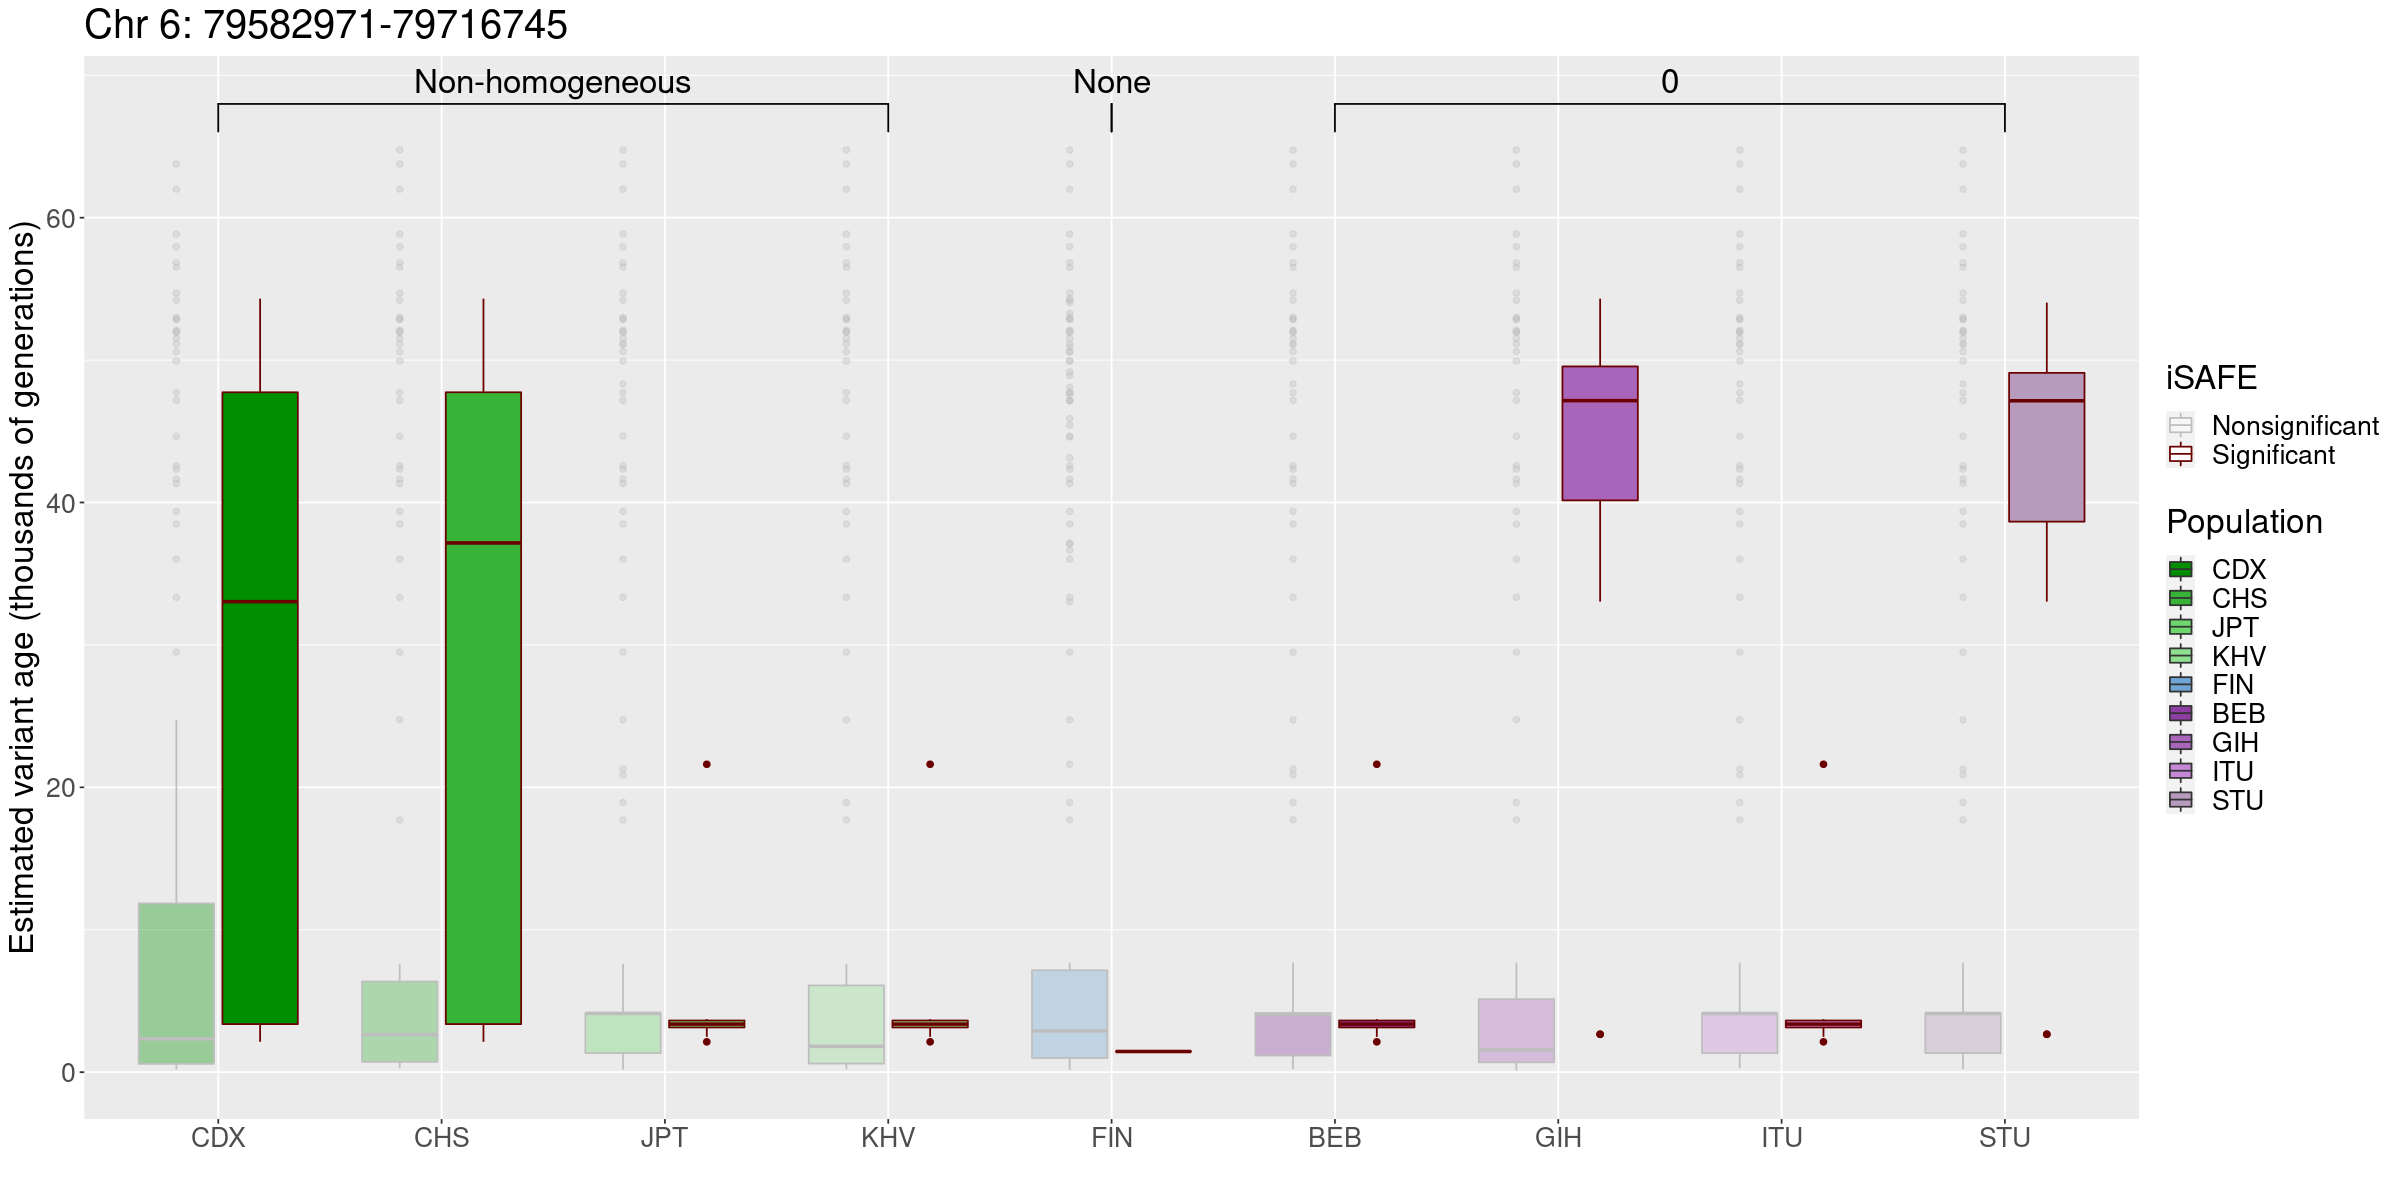

In [31]:
diferencia_edats(6, 79582971, 79716745, AMR = FALSE) #IRAK1BP1 Dona la sensació de que hi hagin hagut 2 sweeps selectius?

Warning message in data.frame(x = c(min(comp[1], comp[2]), min(comp[1], comp[2]), :
“row names were found from a short variable and have been discarded”
Warning message in data.frame(x = c(min(comp[1], comp[2]), min(comp[1], comp[2]), :
“row names were found from a short variable and have been discarded”
Warning message in data.frame(x = c(min(comp[1], comp[2]), min(comp[1], comp[2]), :
“row names were found from a short variable and have been discarded”
Warning message in data.frame(x = c(min(comp[1], comp[2]), min(comp[1], comp[2]), :
“row names were found from a short variable and have been discarded”
Warning message in data.frame(x = c(min(comp[1], comp[2]), min(comp[1], comp[2]), :
“row names were found from a short variable and have been discarded”


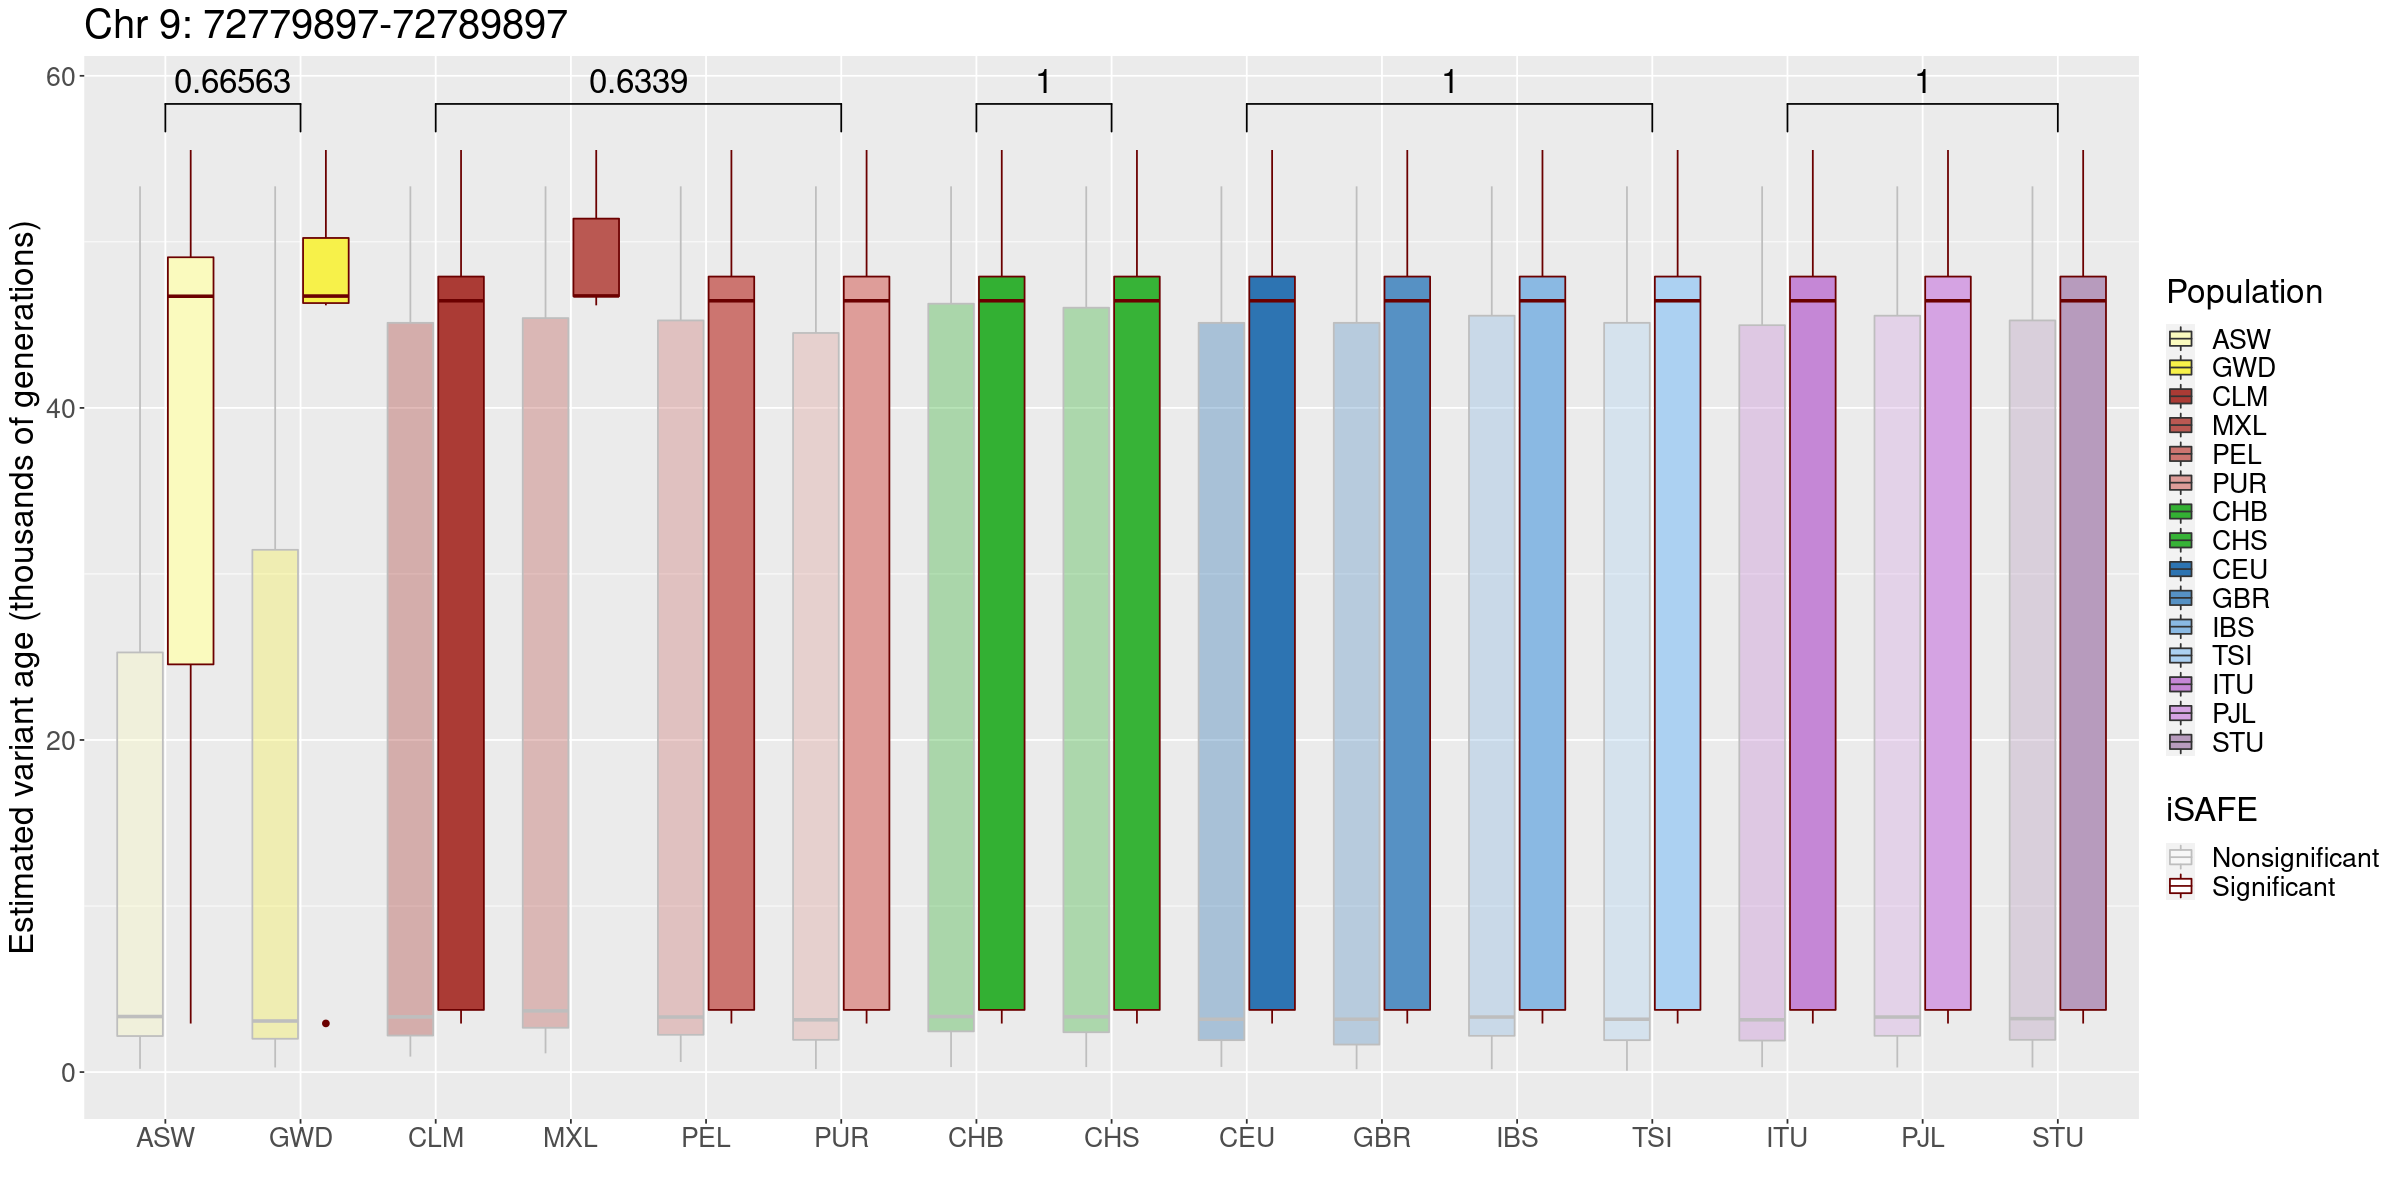

In [33]:
diferencia_edats(9, 72779897, 72789897) #MAMDC2

Warning message in anova.lm(lm(resp.mean ~ d)):
“ANOVA F-tests on an essentially perfect fit are unreliable”
Warning message in anova.lm(lm(resp.mean ~ d)):
“ANOVA F-tests on an essentially perfect fit are unreliable”
Warning message in anova.lm(lm(resp.mean ~ d)):
“ANOVA F-tests on an essentially perfect fit are unreliable”
Warning message in data.frame(x = c(min(comp[1], comp[2]), min(comp[1], comp[2]), :
“row names were found from a short variable and have been discarded”
Warning message in data.frame(x = c(min(comp[1], comp[2]), min(comp[1], comp[2]), :
“row names were found from a short variable and have been discarded”
Warning message in data.frame(x = c(min(comp[1], comp[2]), min(comp[1], comp[2]), :
“row names were found from a short variable and have been discarded”


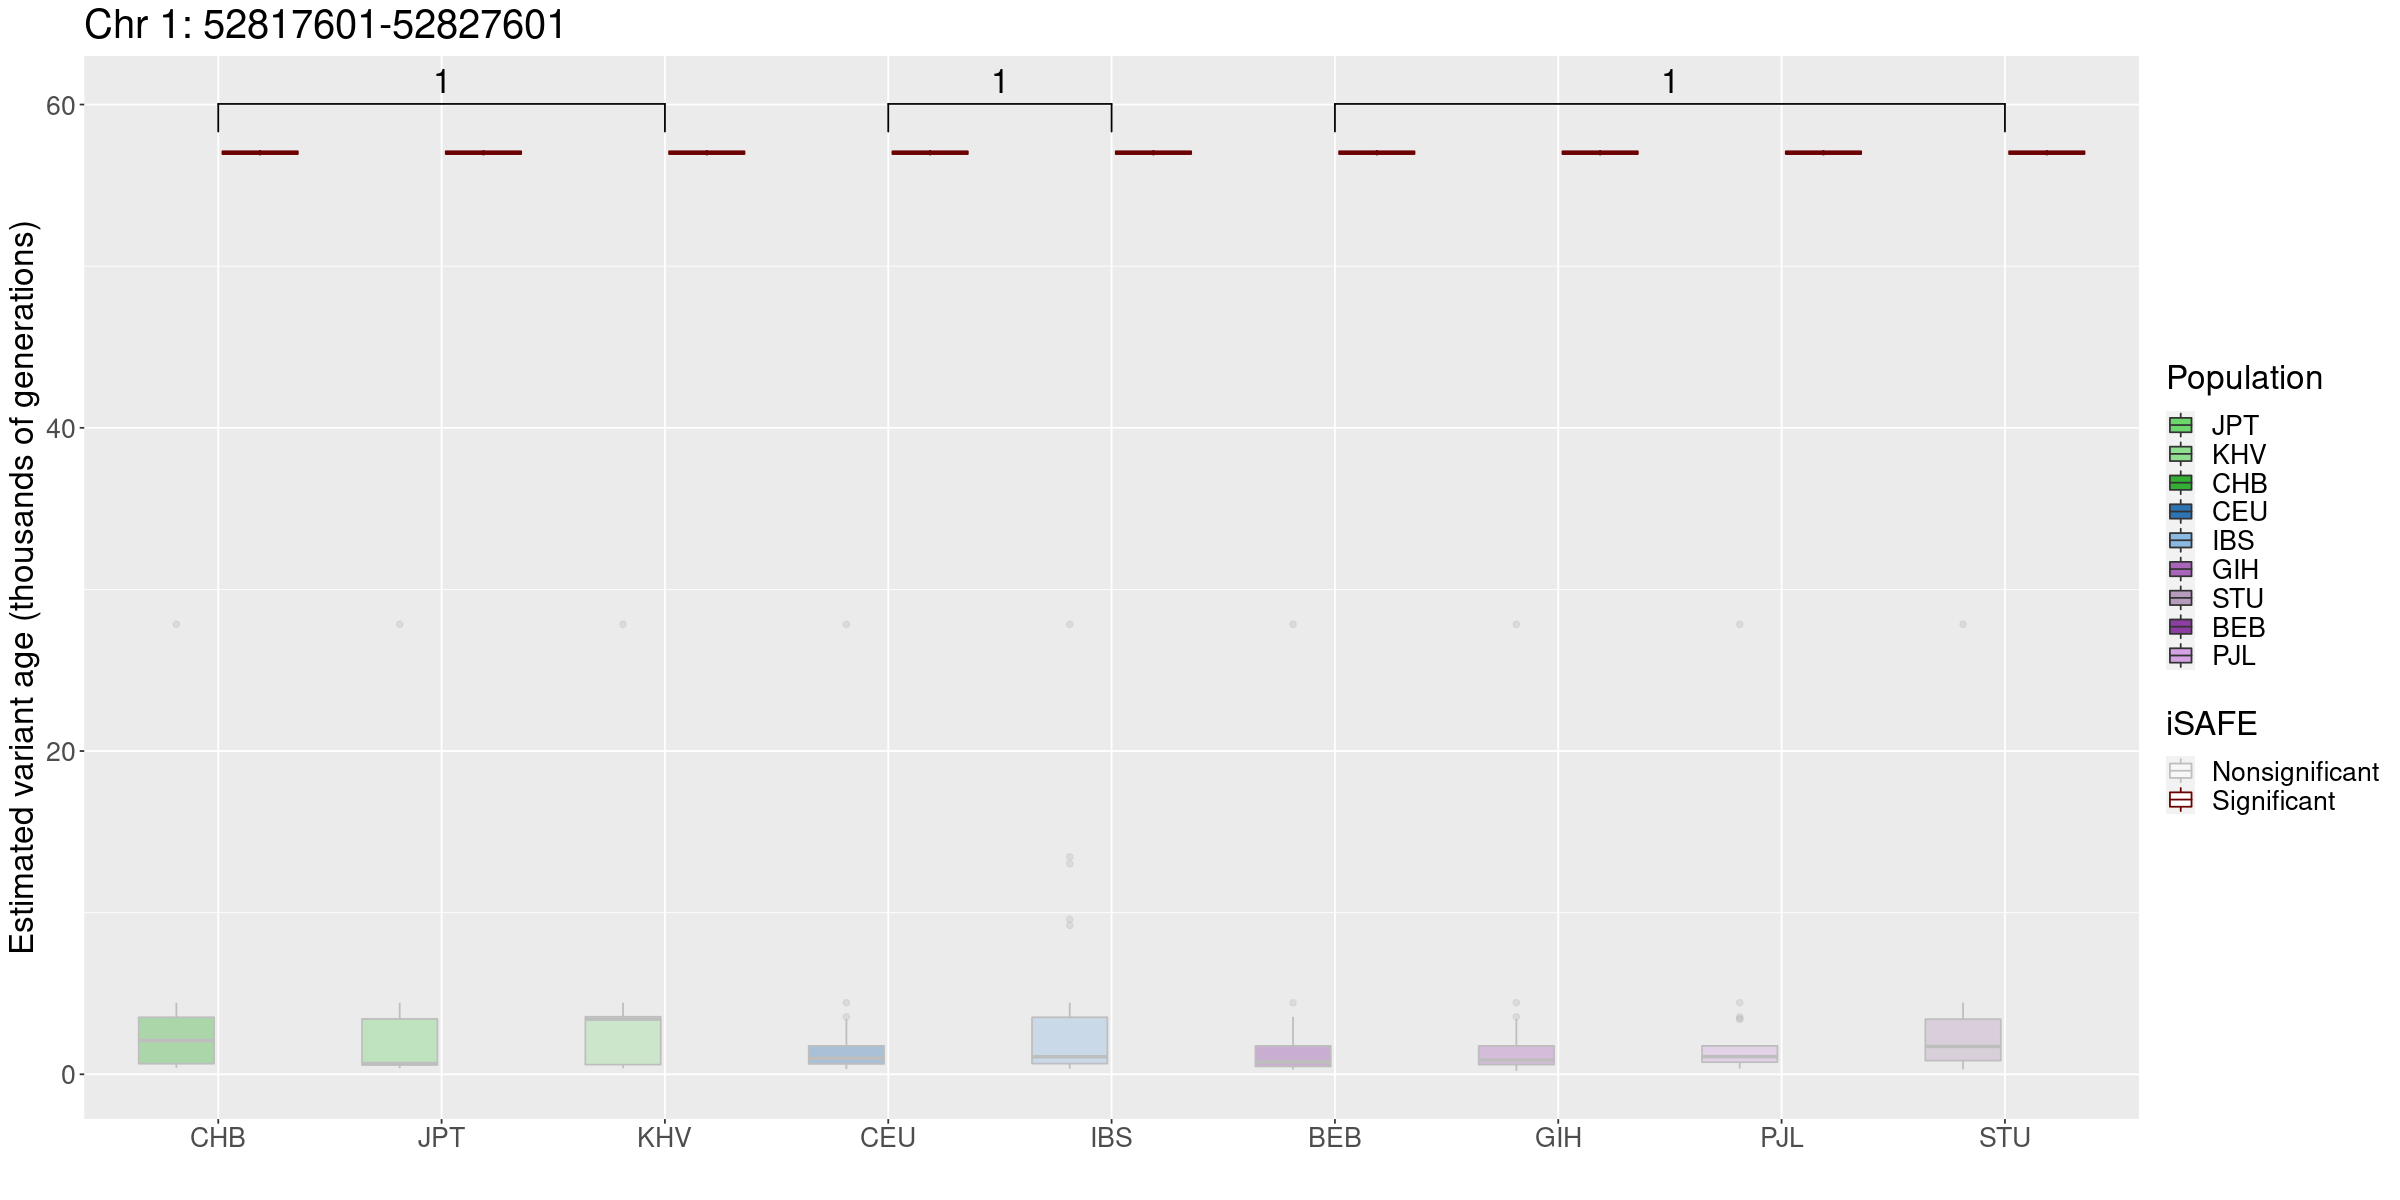

In [34]:
diferencia_edats(1, 52817601, 52827601, AMR = FALSE) 

Warning message in data.frame(x = c(min(comp[1], comp[2]), min(comp[1], comp[2]), :
“row names were found from a short variable and have been discarded”
Warning message in data.frame(x = c(min(comp[1], comp[2]), min(comp[1], comp[2]), :
“row names were found from a short variable and have been discarded”


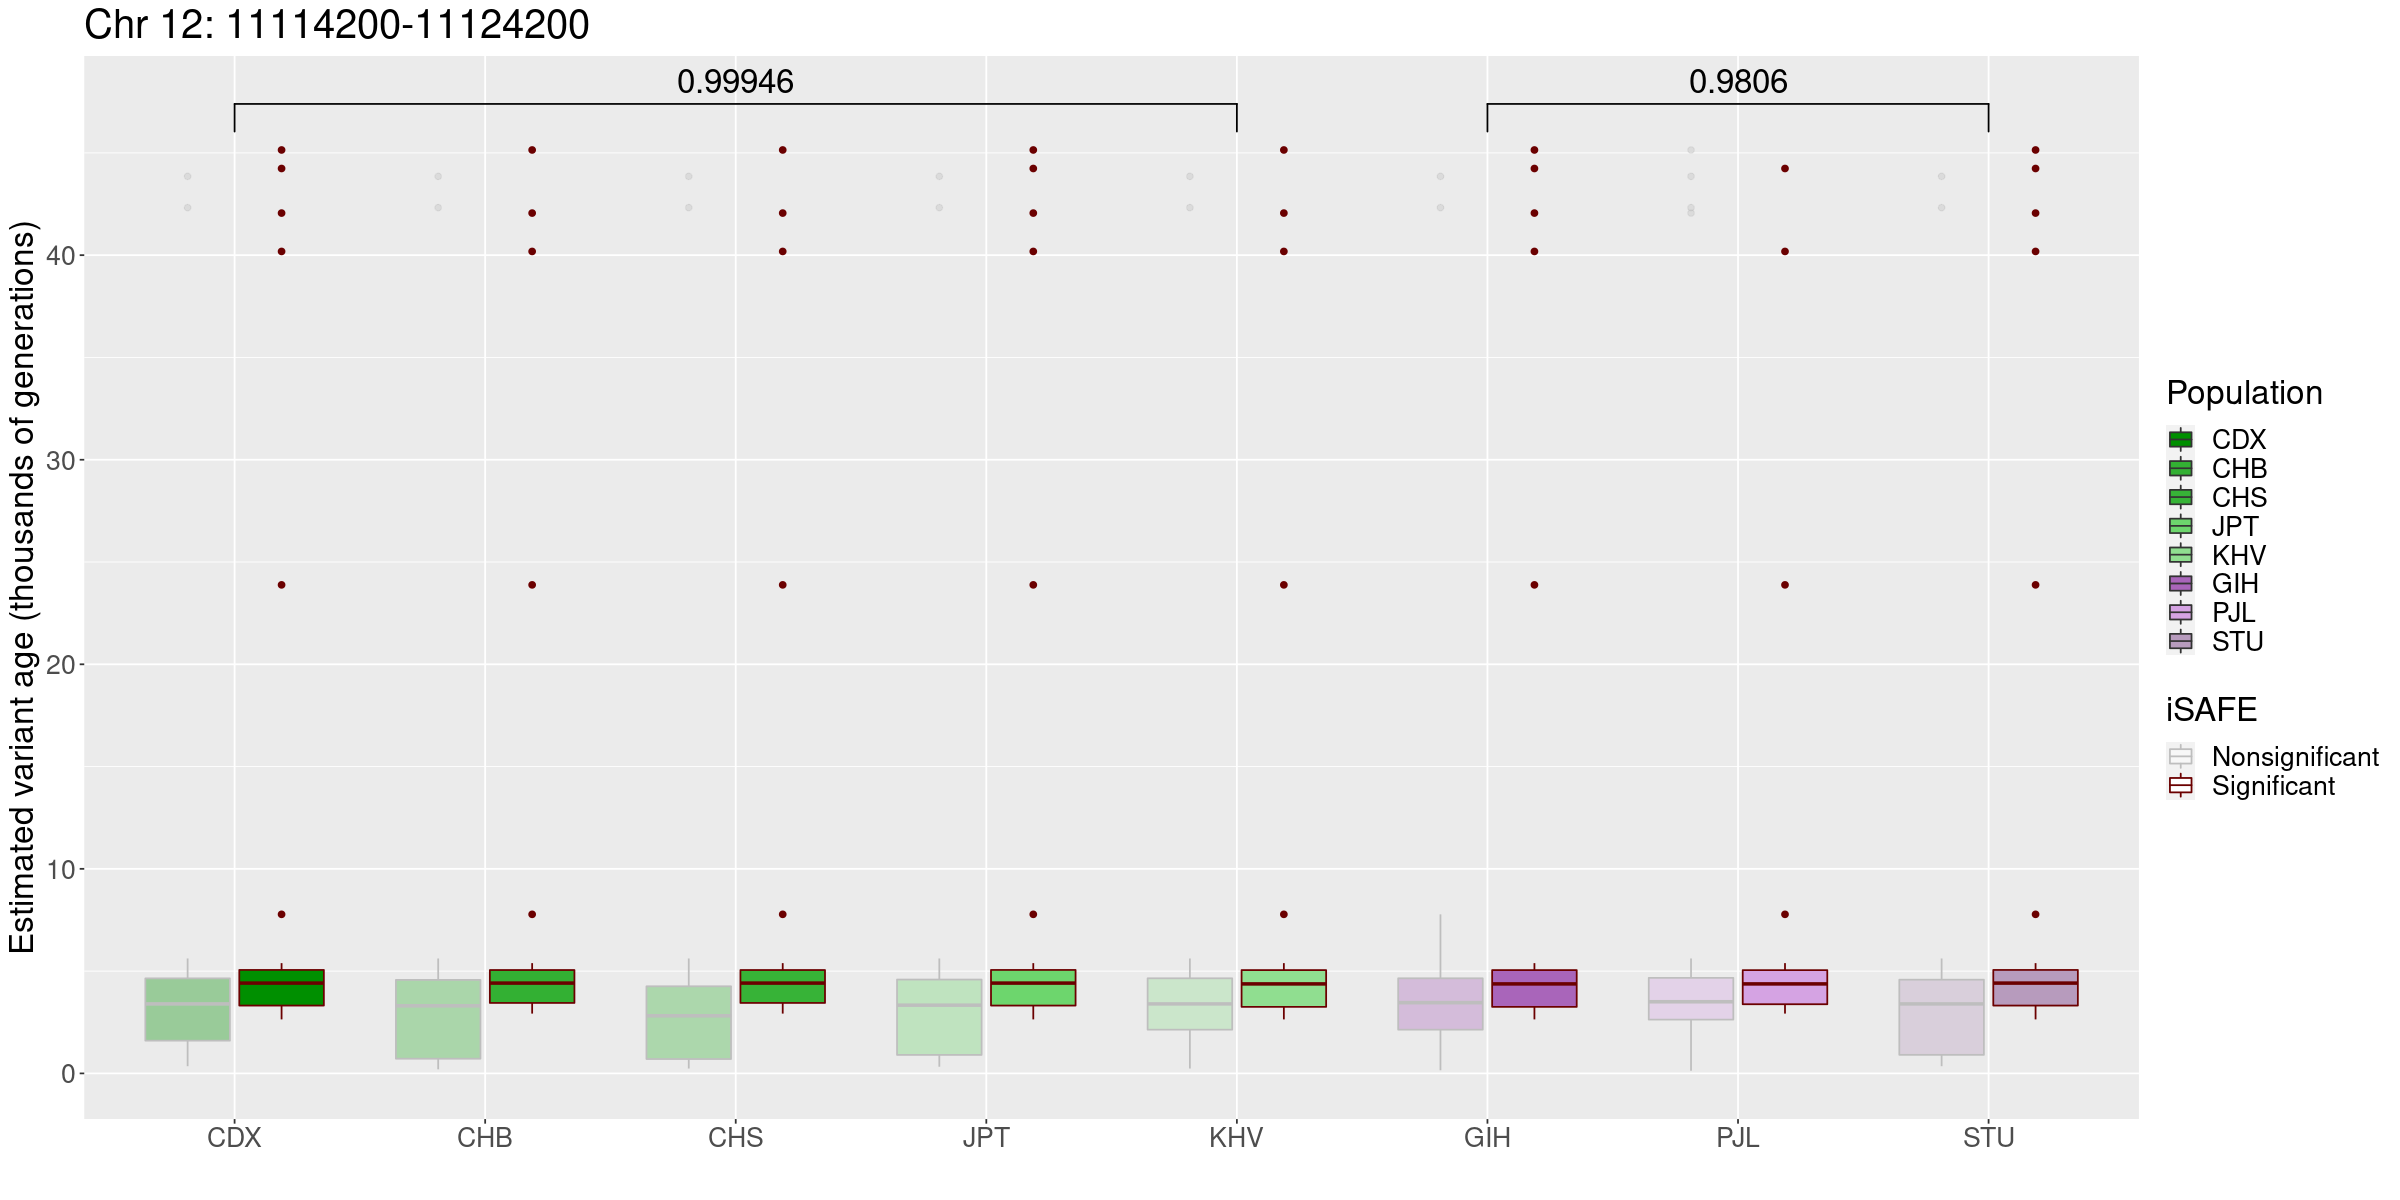

In [35]:
diferencia_edats(12, 11114200, 11124200, AMR = FALSE)  #PRR4,TAS2R14,PRH1,AC018630.6

Warning message in data.frame(x = c(min(comp[1], comp[2]), min(comp[1], comp[2]), :
“row names were found from a short variable and have been discarded”
Warning message in data.frame(x = c(min(comp[1], comp[2]), min(comp[1], comp[2]), :
“row names were found from a short variable and have been discarded”
Warning message in data.frame(x = c(min(comp[1], comp[2]), min(comp[1], comp[2]), :
“row names were found from a short variable and have been discarded”
Warning message in data.frame(x = c(min(comp[1], comp[2]), min(comp[1], comp[2]), :
“row names were found from a short variable and have been discarded”


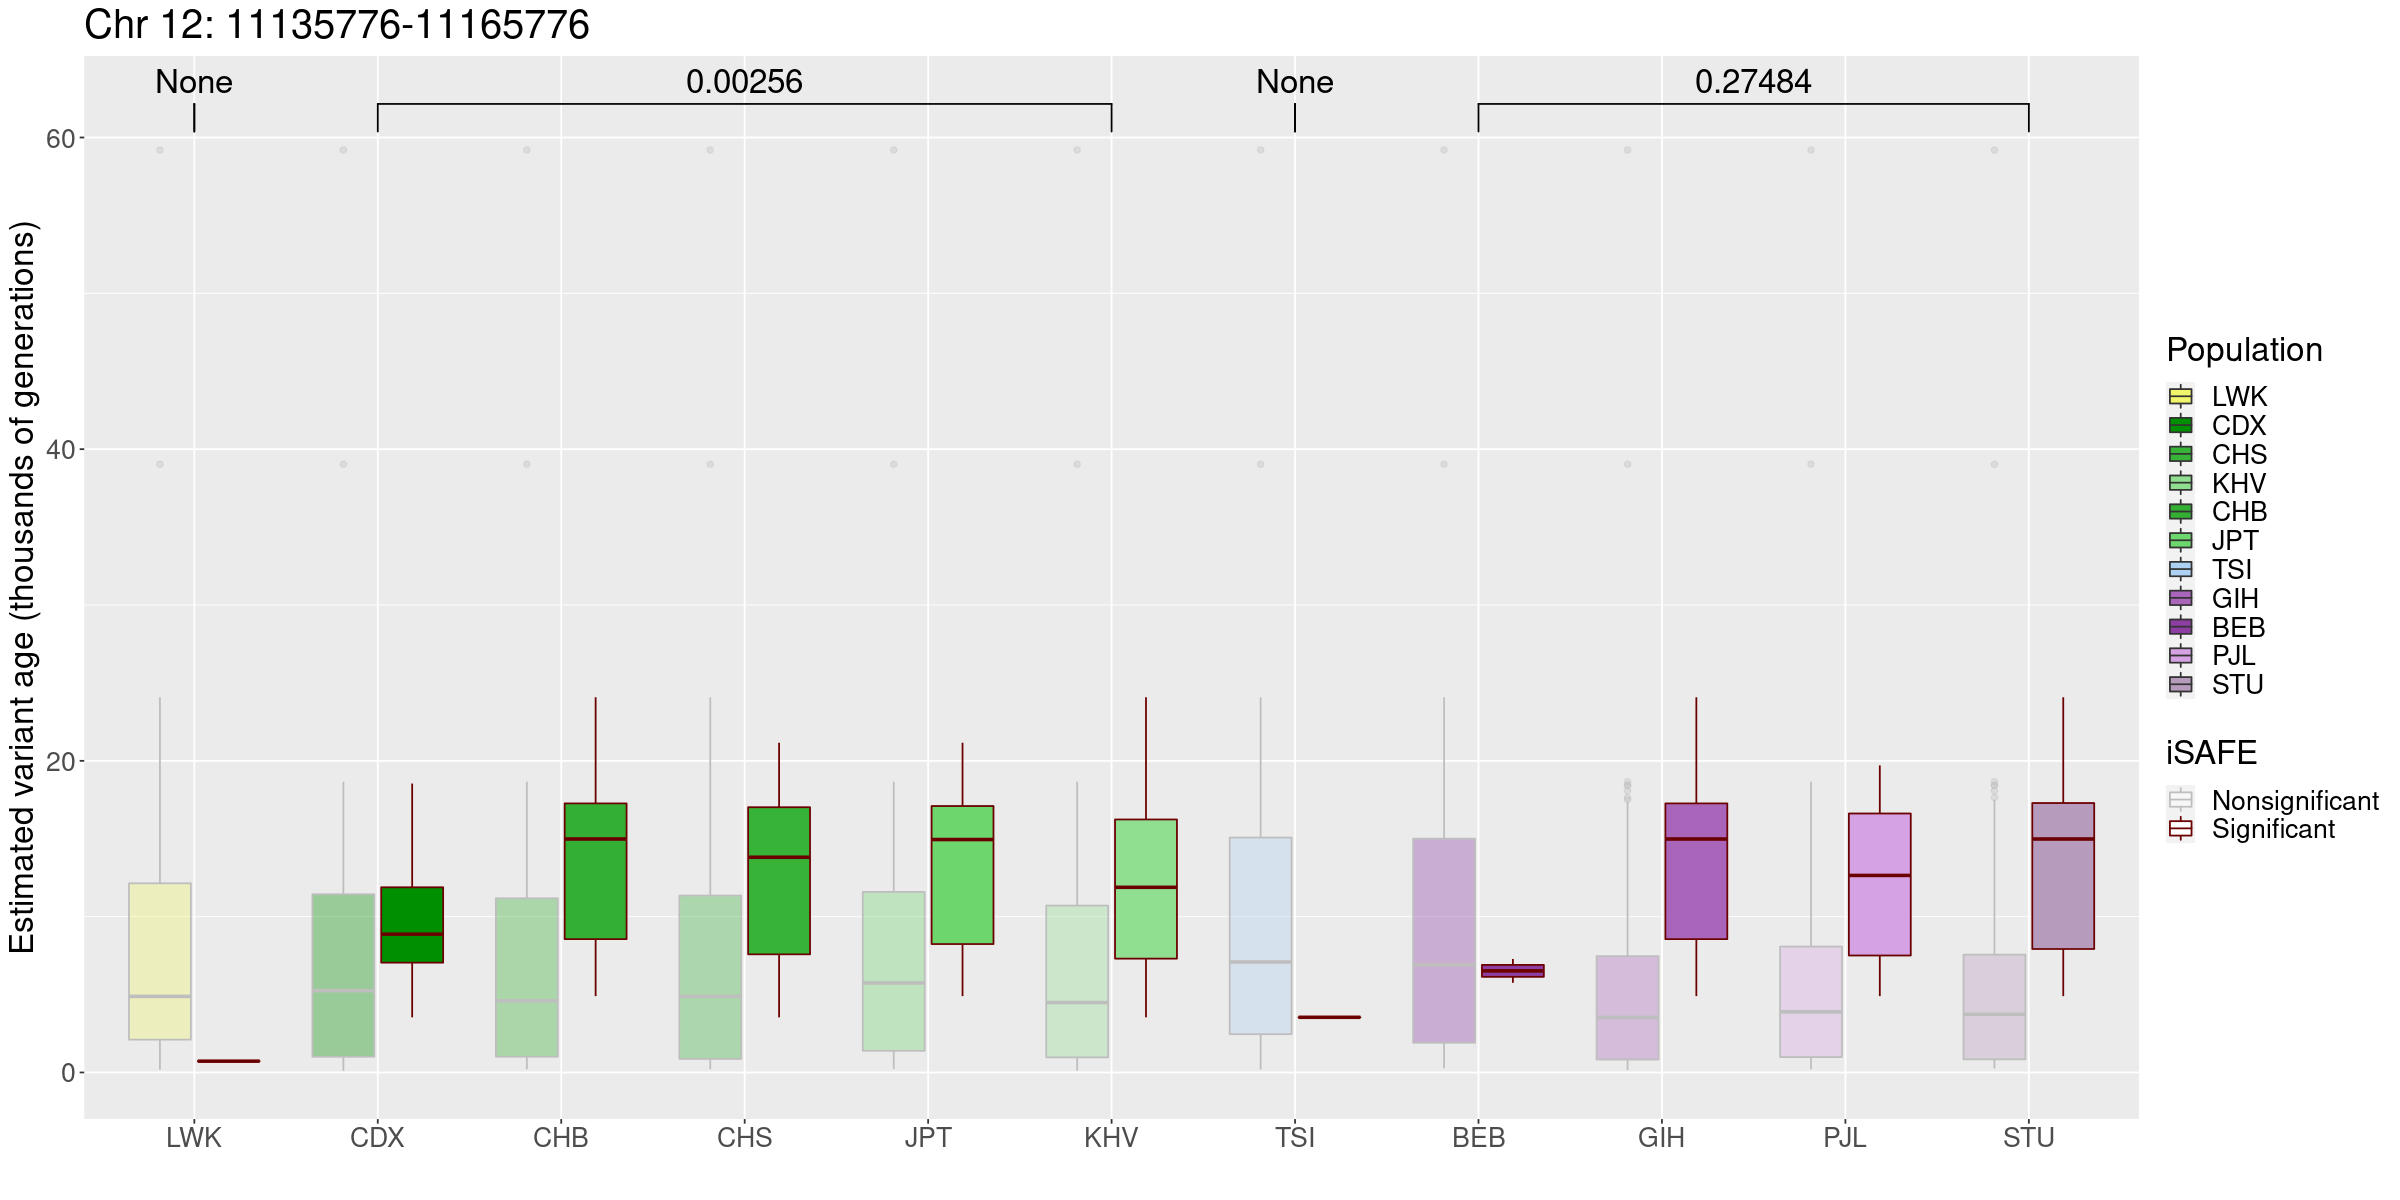

In [36]:
diferencia_edats(12, 11135776, 11165776, AMR = FALSE) #PRR4,TAS2R50,TAS2R14,PRH1,AC018630.6,TAS2R20

Warning message in data.frame(x = c(min(comp[1], comp[2]), min(comp[1], comp[2]), :
“row names were found from a short variable and have been discarded”
Warning message in data.frame(x = c(min(comp[1], comp[2]), min(comp[1], comp[2]), :
“row names were found from a short variable and have been discarded”
Warning message in data.frame(x = c(min(comp[1], comp[2]), min(comp[1], comp[2]), :
“row names were found from a short variable and have been discarded”


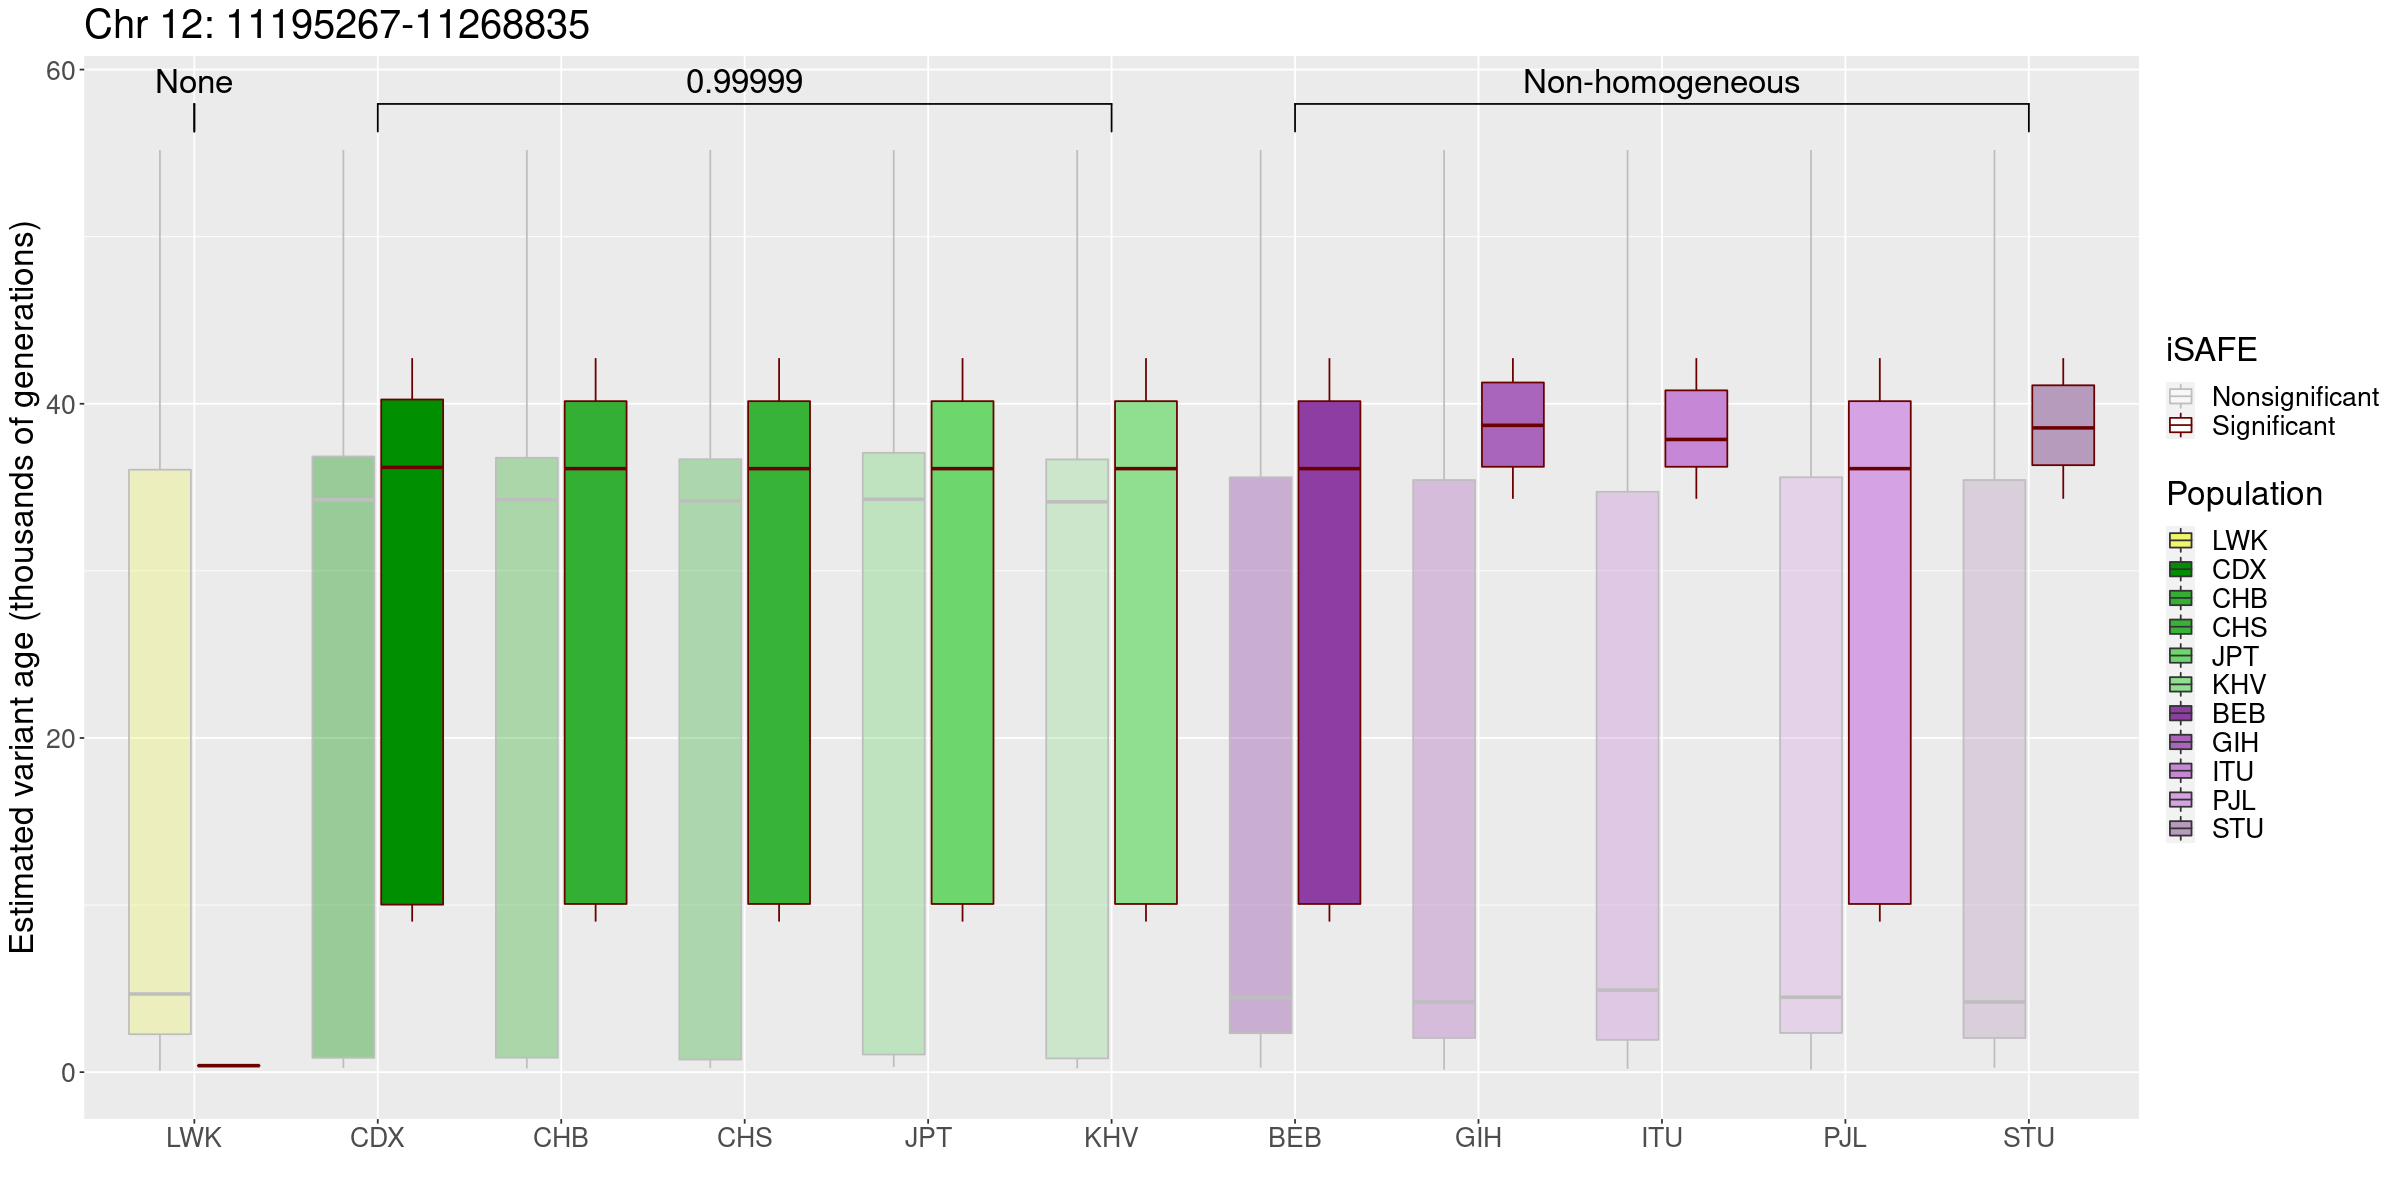

In [37]:
diferencia_edats(12, 11195267, 11268835, AMR = FALSE) #PRR4,TAS2R14,PRH1,AC018630.6,TAS2R46

Warning message in data.frame(x = c(min(comp[1], comp[2]), min(comp[1], comp[2]), :
“row names were found from a short variable and have been discarded”
Warning message in data.frame(x = c(min(comp[1], comp[2]), min(comp[1], comp[2]), :
“row names were found from a short variable and have been discarded”


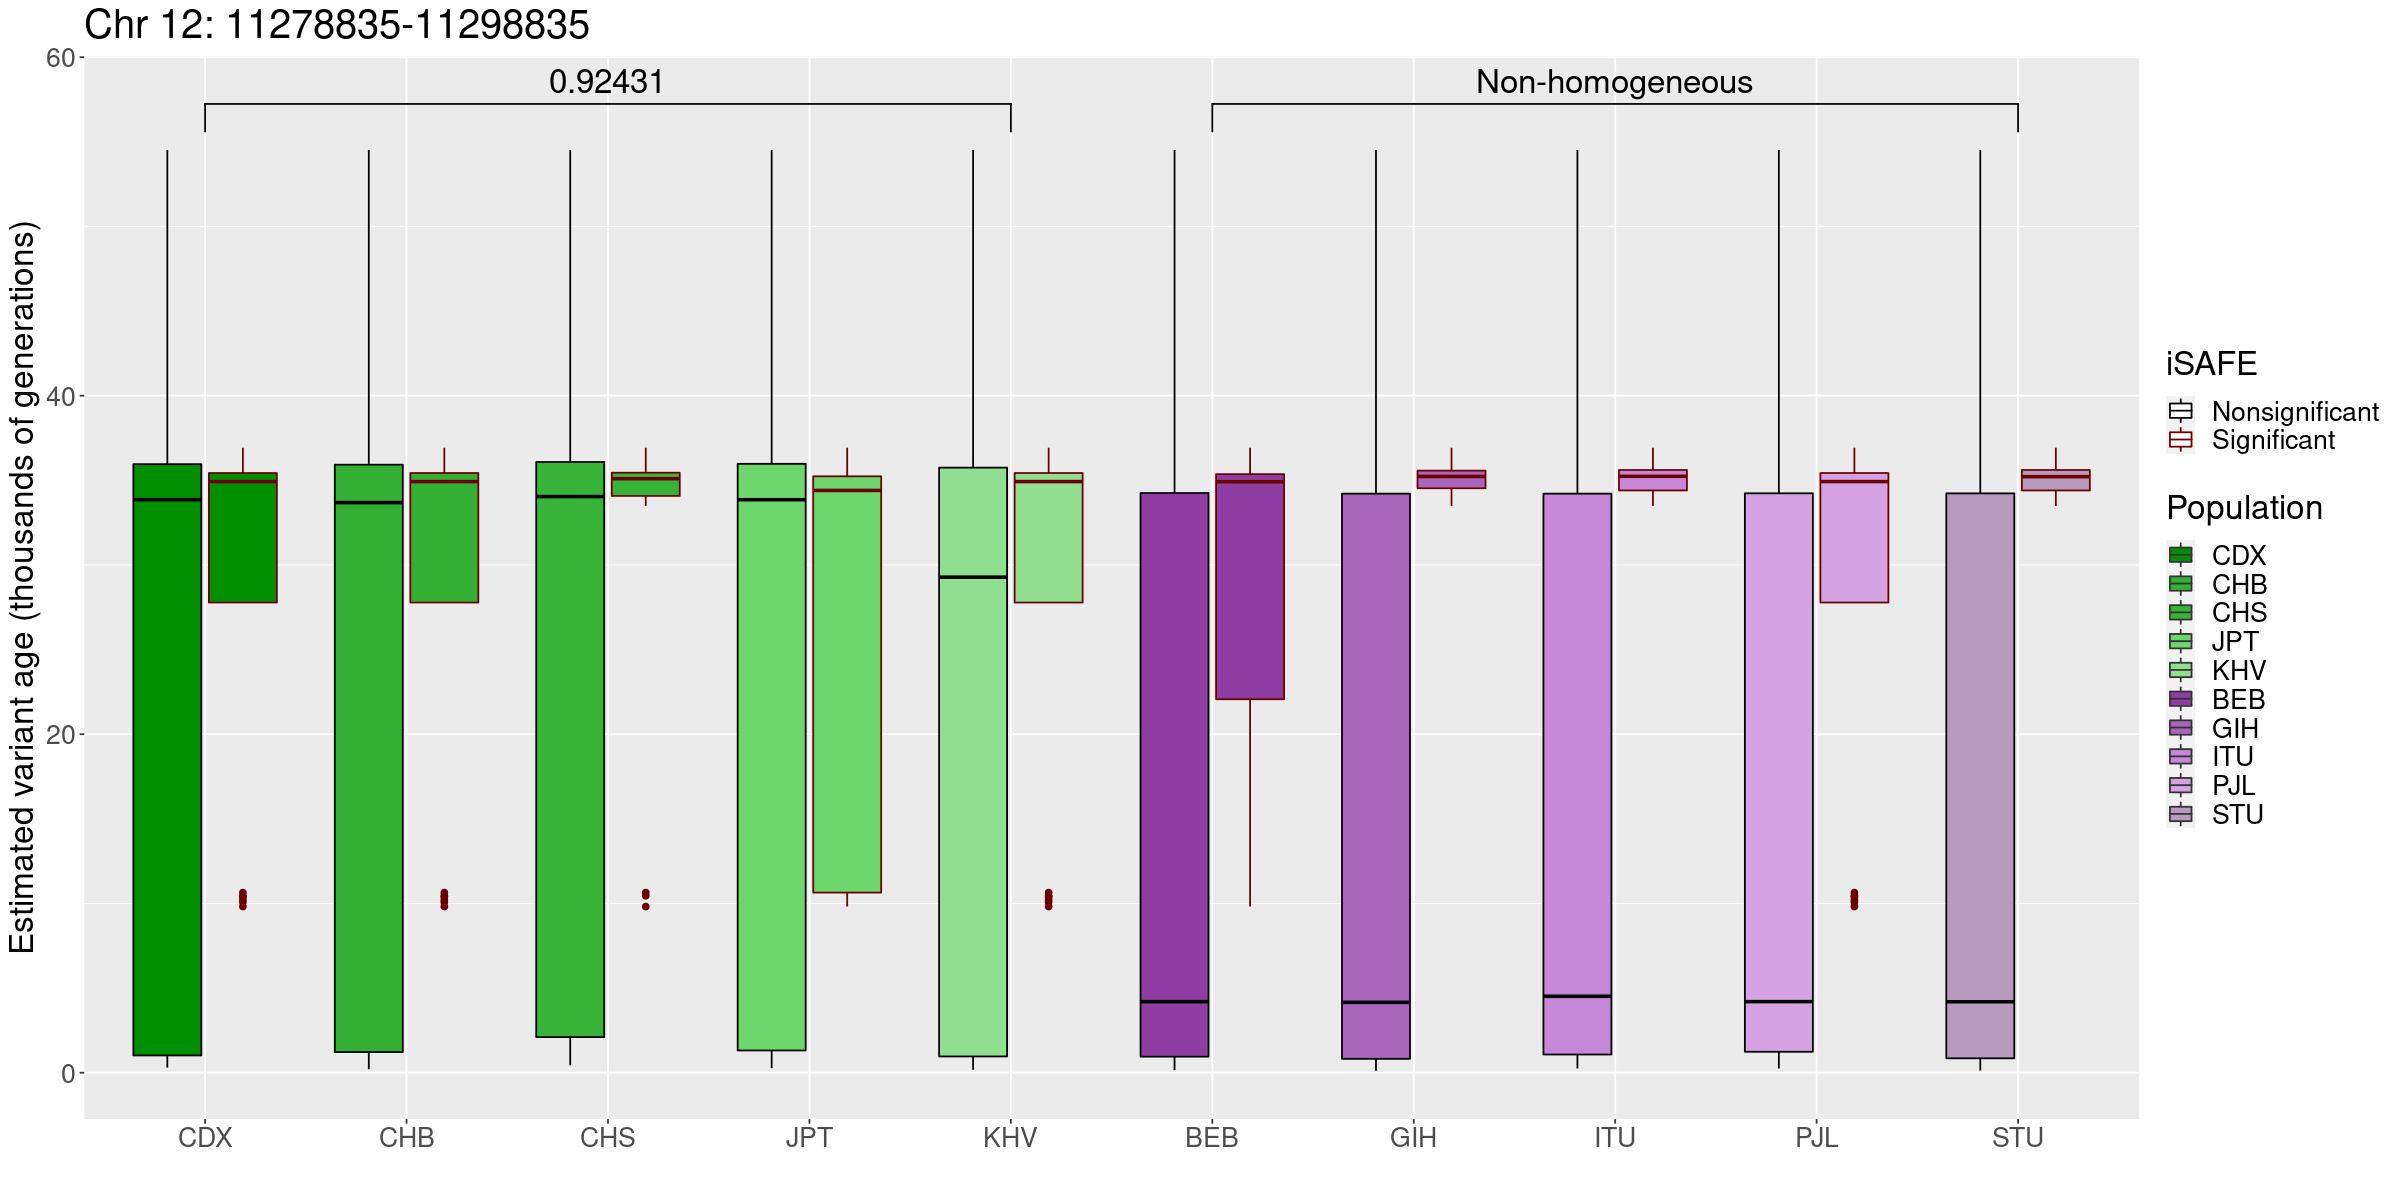

In [4]:
diferencia_edats(12, 11278835, 11298835, AMR = FALSE) #PRR4,TAS2R14,PRH1,TAS2R30,AC018630.6

Warning message in data.frame(x = c(min(comp[1], comp[2]), min(comp[1], comp[2]), :
“row names were found from a short variable and have been discarded”
Warning message in data.frame(x = c(min(comp[1], comp[2]), min(comp[1], comp[2]), :
“row names were found from a short variable and have been discarded”


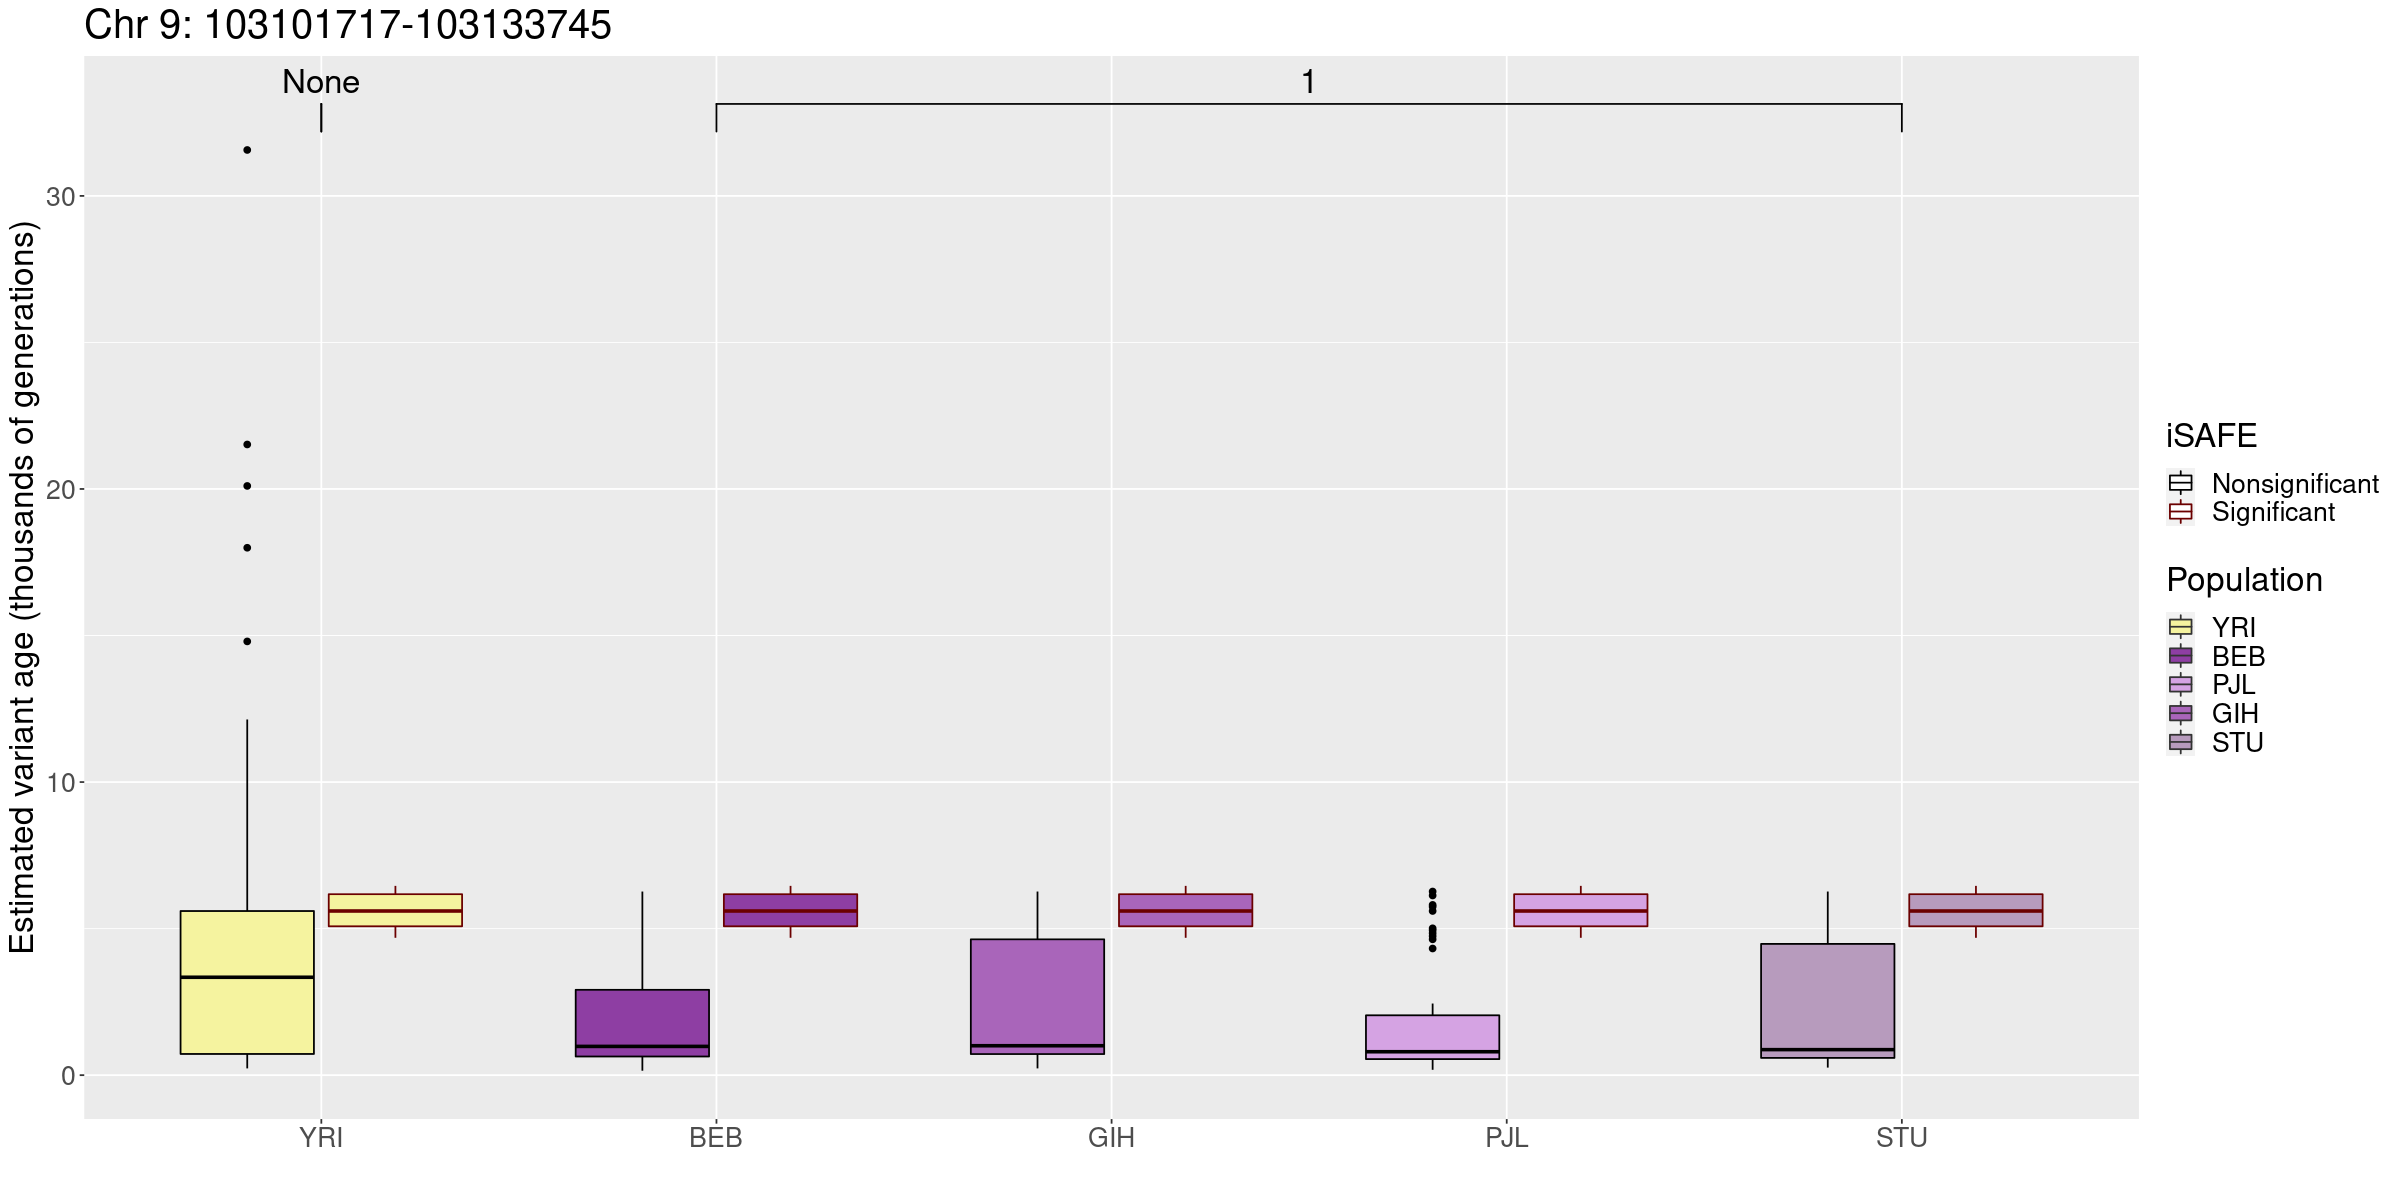

In [3]:
diferencia_edats(9, 103101717, 103133745, AMR = FALSE) #PRR4,TAS2R14,PRH1,TAS2R30,AC018630.6